# Inference on Epidemic Data

Antonaci Edoardo - 1234431

Crudele Maria Michele - 2021858

Zanola Andrea - 2027588

## SIR model - Brief Introduction
S-I-R is a compartimental model used in epidemiology in order to describe the dynamics of an epdemic and it's one of the most famous and studied epidemiological model due to its semplicity.

The SIR model is composed by 3 compartments, i.e it splits the population in 3 categories Suscettibles, Infectous and Recovered. The main idea is that an epidemic can be modeled as a interaction between these categories; obviously if we increment the number of compartments we are increasing the complexity of the model (as an example in a NATURE's paper, COVID is described with a SIDARTHE model, i.e 8 compartments).

The dynamics of an epidemic is intrinsically stochastic, so the right tool to use is the Master Equation. However, if the population is large $N\rightarrow \infty$, we can keep the deterministic model, due to the fact that flactuations goes like  $\sim \frac{1}{\sqrt{N}}$.

The deterministic equations for the SIR model are:

$$
\begin{cases}
\begin{align}
\frac{dS}{dt} &=-\beta\frac{SI}{N}\\
\frac{dI}{dt} &=+\beta\frac{SI}{N} -\gamma I \\
\frac{dR}{dt} &=+\gamma I \\
\end{align}
\end{cases}
$$

where $\beta$ is the "transmission rate" and $\gamma$ is the "recovery rate"; it's inverse give the recovery time $[days]$. Thanks to the definition of these natural quantities we can define the "basic reproduction number" $R_{0}$ as:

$$R_{0}=\frac{\beta}{\gamma}$$

Obviously a real potential epidemic could not be described by a deterministic model beacuse we have to keep in consideration the natural statistical fluctuations; this can be achieved by introducing the Gillespie's Algorithm. 

Gillespie's Algorithm is able to produce exact solutions of the original Master Equation that describe the model, i.e it gives us possibile real trajectories described by the SIR model.

We report below a comparison between stochastic vs deterministic simulations for different $N$.
![alt text](CURVES.jpg "Title")

In [1]:
#---LIBRARIES---
library(ggplot2)
library(gridExtra)
library(rstan)
library(tidyverse)
library(deSolve)
library(EpiDynamics)
library(magrittr)
library(repr)
library(coda)
library(rjags)
library(tidybayes)
library(dplyr)
library(tidyr)

Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.1       ✔ purrr   0.3.2  
✔ tidyr   0.8.3       ✔ dplyr   0.8.0.1
✔ readr   1.3.1       ✔ stringr 1.4.0  
✔ tibble  2.1.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()  

In [2]:
options(repr.plot.width=12, repr.plot.height=7) # graphics setting
options(mc.cores = parallel::detectCores())     # to run multiple MCMC in parallel
options(warn=-1)                                #to avoid warning when pairs plot run (SEIR model)
rstan_options(auto_write = TRUE)                # to avoid compiling the models again if there are no changes

In [3]:
#--COLOUR_PALETTE--
c_simu <- "mediumseagreen"
c_posterior = "orange"
c_prior = "aquamarine2"

## Inference of the $R_0$ of a Gillespie Trajectory with Stan
In this section we infere the Basic Reproduction Number ($R_0$) of a Gillespie trajectory using a Stan model that solves Ordinary Differential Equations (ODEs).

### Trajectory Generation with Gillespie Algorithm



In [4]:
#---GILLESPIE's ALGORITHM---

gillespie <- function(N, P) {
    
    lp <- 20000
    Xs <- matrix(0, 4, lp)
    Xs[, 1] <- c(N-1, 1, 0, 0)
    a <- NULL
    
    for (i in seq(1,lp-1,1)) {
        a[1] <- P[1]*Xs[1,i]*Xs[2,i]/N
        a[2] <- P[2]*Xs[2,i]
        a0   <- sum(a)

        if (a0==0) { break }

        tau <- -log(runif(1))/a0
        r2  <- runif(1)*a0
        
        if (r2<=a[1])
            { v <- c(-1,1,0, tau) } # S+I -> I+I
        else
            { v <- c(0,-1,1, tau) } # I -> R

        Xs[,i+1] <- Xs[,i]+v

        if (Xs[2,i+1]==0)
            { J=i+1 }
    }

    return(Xs[,seq(1,J)])
}

beta  <- 0.9
gamma <- 0.4
cat("The Gillespie trajectory is generated with R0 = beta/gamma =", beta/gamma)

set.seed(0)
Xmatt <- gillespie(N=1000, P=c(beta, gamma)) %>% t() %>% as.data.frame()
names(Xmatt) <- c("S", "I", "R", "t")


The Gillespie trajectory is generated with R0 = beta/gamma = 2.25

We keep only some significant part of the trajectory in order to make the MCMC faster. The starting elbow and the tail of the curve are the most important parts, so we keep more points there.  
To this end, we create a mask made up of three masks, each sampling from one of the three sections in which we split the curve.
Then, we create a dataframe with the data, having one state (S, I, R) per column, together with the time in the fourth column.

In [5]:
mask1 <- seq(2, nrow(Xmatt)/4, length=10)
mask2 <- seq(nrow(Xmatt)/4+50, nrow(Xmatt)*3/4, length=5)
mask3 <- seq(nrow(Xmatt)*3/4+200, nrow(Xmatt), length=10)
mask <- c(mask1, mask2, mask3)

Xmat <- Xmatt[mask, ]
names(Xmat) <- c("S", "I", "R", "t")

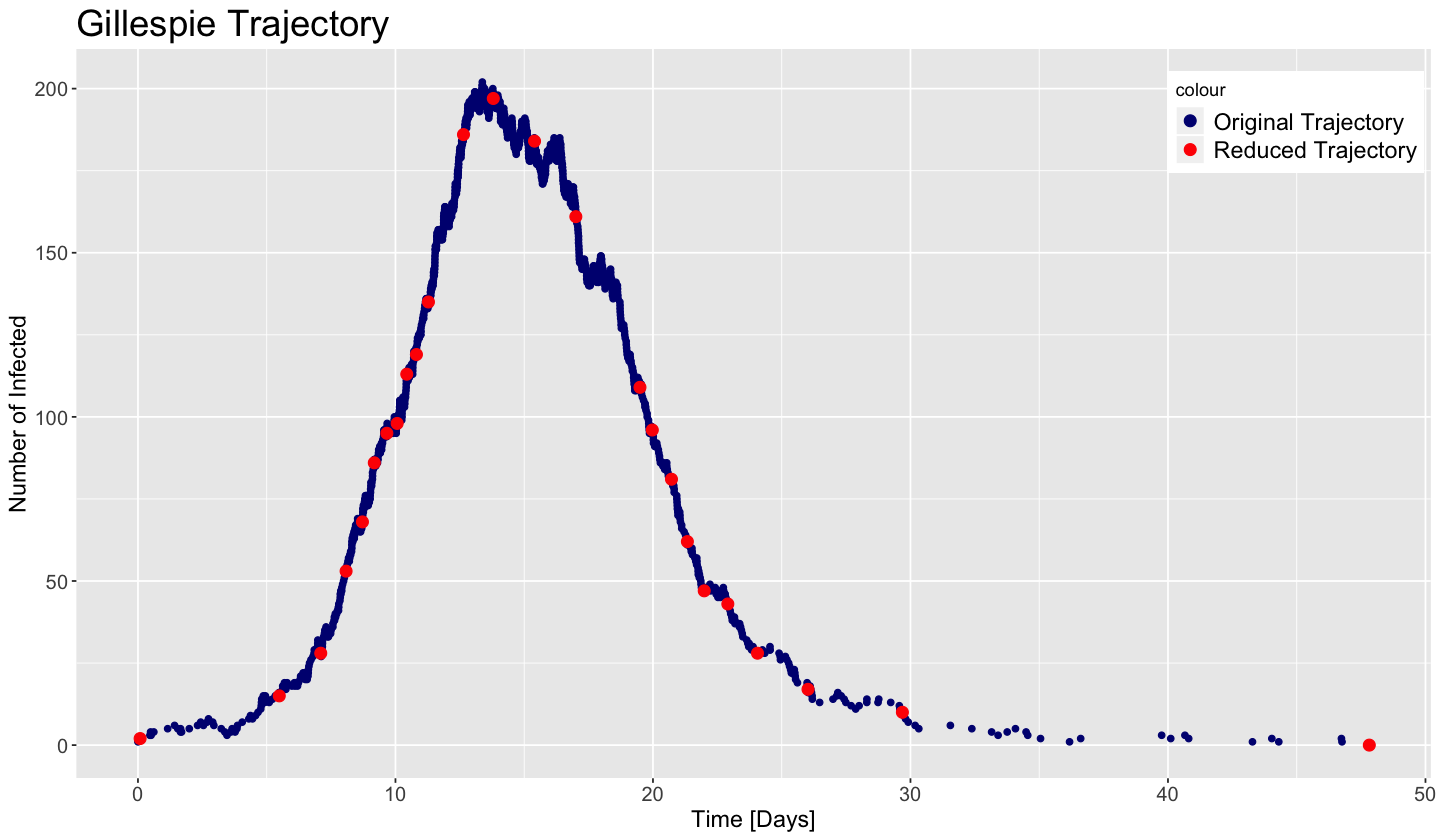

In [6]:
ggplot() + geom_point( data=Xmatt, aes(x=t, y=I, color='Original Trajectory')) +
           geom_point( data=Xmat,  aes(x=t, y=I,  color='Reduced Trajectory'), cex = 3) +
           labs(title = "Gillespie Trajectory", x = "Time [Days]", y = "Number of Infected")+
           scale_color_manual(values = c("Original Trajectory"="navy","Reduced Trajectory"="red"))+
           theme(axis.text=element_text(size=12), axis.title=element_text(size=14),
                 plot.title = element_text(size=22), legend.text = element_text(size=14),
                 legend.position = c(.9, .9))

### The model
To specify a model in Stan, we need to code three main blocks: data, parameters, and model. 

* In the **data** block, we declare the fixed variables, $Y$ and in the **parameters** block the model parameters, $\pmb{θ}$. 

* In the **model** block, we specify the priors and the likelihood. 

* It is possible to do further operations on the fixed data and on the model parameters by using the **transformed data** and the **transformed parameters** blocks, respectively.

* Additional quantities which depend on the parameters, but are not required to compute the log joint density can be computed in **generated quantities** block. 

* Finally, the **function block** can be used to declare functions which we can call in all the operative blocks, i.e. all blocks but data and parameters.

### The Blocks

1. The function **sir** returns an array of real numbers. It has five arguments with a specific signature that must be exactly respected. The first two arguments are time steps and relative counts. The next three arguments relate to ODE inputs. These are concatenated inside arrays of real or integer numbers.  

    It is crucial to distinguish variables which are model parameters from variables which stay fixed as the sampler explores the parameter space. Here, theta contains ODE inputs that depend on $\beta$ and $\gamma$. Quantities that influence the ODE but remain fixed during the whole procedure (e.g. the population size) are passed using x_r and x_i, depending on whether they are real or integers.  
    
    Distinguishing parameters and fixed variables is a matter of computational efficiency. We assume that the total population remains constant, so the three derivatives $dS/dt$, $dI/dt$, $dR/dt$ sum up to $0$: we can use this fact to improve computational efficiency of the sir function by deriving the value of $dI/dt$ from $dS/dt$ and $dR/dt$.

2. In the **data** block we declare known variables; then, in the **transformed data** block, we transform our data to match the rigid signature of sir (with x_r being of length 0 because we have nothing to put in it);

3. We next declare the model **parameters**: $\langle \text{lower}=a, \text{upper}=b\rangle$ bounds their values.  
    Note that this is how we put a truncated prior distribution on a parameter. Since we want to incorporate randomness into our model to account for our imperfect knowledge of the model parameters, natural variation and the imperfect fit of the model to reality, we also include an additional over-dispersion parameter $φ$.

4. We make some **transformation** on the parameters: $φ$ is reparametrized as its inverse (see [1]). Theta holds the parameters together. 

    Finally, we evaluate the solution numerically by using one of Stan’s numerical integrators (see [2]): the Runge-Kutta 4th/5th, that returns a two-dimensional array with the solution of each compartment at each time point in $t_{s}$.  
    Notice that we pass to the integrator the arguments theta, x_r, and x_i, which are in turn passed to the function sir each time the integrator is being called. Each integration goes from $t_{0}$ to $\tau$, the time of the last observation.

5. With the ODE solution, $y$, in hand, the only thing left to do is to code the prior and likelihood distribution in the **model** block.  
    * For the transmission rate we select a Normal weakly-informative prior that only restricts $\beta$ to be positive and puts a soft higher limit around 4: $p(\beta < 3) = 0.975$. 
    * For the recovery rate, we expresses our belief that $\gamma$ has to be positive and that $p(\gamma \leq 1) = 0.9$. 
    * For the dispersion parameter, we use $p(1/\phi)= \text{Exp}(\lambda=5)$.
    
    As far as the likelihood, we choose to model the number of infected with a count distribution that provides some flexibility regarding dispersion: the negative binomial distribution. This distribution allows us to use $I(t)$ as the expected value and account for over-dispersion through $φ$.

6. Untangled from the inference, we can calculate the basic reproduction number, $R_{0}$, and predictions for the number of cases in the **generated quantities** block.

The computational cost of fitting a model is dominated by operations in the transformed parameters and model blocks, where operations are performed and differentiated once per integration step, i.e. multiple times per iteration.

In [7]:
modelString = "
    functions {real[] sir(real t, real[] y, real[] theta, real[] x_r, int[] x_i) {

          real S = y[1];
          real I = y[2];
          real R = y[3];
          real N = x_i[1];

          real beta = theta[1];
          real gamma = theta[2];

          real dS_dt = -beta * I * S / N;
          real dR_dt =  gamma * I;
          real dI_dt =  -(dS_dt + dR_dt);     
        
          return {dS_dt, dI_dt, dR_dt};
      }
    }

    data {
      int<lower=1> n_days;
      real y0[3];             //initial conditions for SIR
      real t0;                //initial time
      real ts[n_days];        //time instants at which to solve the model
      int N;                  //population
      int cases[n_days];      //collected data
    }

    transformed data {
      real x_r[0];
      int x_i[1] = { N };
    }

    parameters {
      real<lower=0> gamma;    //recovery rate
      real<lower=0> beta;     //infectious contact rate
      real<lower=0> phi_inv;  //over-dispersion parameter
    }

    transformed parameters{
      real y[n_days, 3];
      real phi = 1. / phi_inv; //over-dispersion parameter, reparametrized as its inverse
      {
        real theta[2];
        theta[1] = beta;
        theta[2] = gamma;

        y = integrate_ode_rk45(sir, y0, t0, ts, theta, x_r, x_i);
      }
    }

    model {
      //priors
      beta ~ normal(1, 1);
      gamma ~ normal(0.4, 0.5);
      phi_inv ~ exponential(5);

      //sampling distribution
      //col(matrix x, int n) - The n-th column of matrix x. Here the number of infected people 
      cases ~ neg_binomial_2(col(to_matrix(y), 2), phi);
    }

    generated quantities {
      real R0 = beta / gamma;
      real recovery_time = 1 / gamma;
      real pred_cases[n_days];
      pred_cases = neg_binomial_2_rng(col(to_matrix(y), 2)+0.00001, phi+0.00001);
    }"

In [8]:
model <- stan_model(model_code = modelString) # here we compile the model

We now collect the data into a list that will be passed to Stan.

In [9]:
# time series of cases
cases <- Xmat$I          # infected

# total population
N <- 1000                # population

# time steps
n_days <- length(cases)
t <- (Xmat$t)
t0 = 0 

#initial conditions
i0 <- 1             # initial infected
s0 <- N - i0        # initial susceptible
r0 <- 0             # initial recovered

y0 = c(S = s0, I = i0, R = r0)

# data for Stan
data_sir <- list(n_days = n_days, y0 = y0, t0 = t0, ts = t, N = N, cases = cases)

### Checking priors

Here we check wether or not our priors are good for the data we are dealing with. We have generated Gillespie trajectory with parameters $\beta = 0.9$ and $\gamma = 0.4$, so our priors have to allow these values in order to end up with a good inference process.
Of course, usually we do not know the real parameters of the model we are analyzing, so we use weakly-informative priors that allow for every reasonable value but exclude highly improbable scenarios.

To conduct a prior predictive check in Stan, we take the same model as before and remove the likelihood term from it. In this way, the parameters are not fitted to the data and are thus sampled from their prior distribution.

In [10]:
modelStringPrior = "
    functions {real[] sir(real t, real[] y, real[] theta, 
                 real[] x_r, int[] x_i) {

          real S = y[1];
          real I = y[2];
          real R = y[3];
          real N = x_i[1];

          real beta = theta[1];
          real gamma = theta[2];

          real dS_dt = -beta * I * S / N;
          real dR_dt =  gamma * I;
          real dI_dt =  -(dS_dt + dR_dt);     
        
          return {dS_dt, dI_dt, dR_dt};
      }
    }

    data {
      int<lower=1> n_days;
      real y0[3];
      real t0;
      real ts[n_days];
      int N;
      int cases[n_days];
    }

    transformed data {
      real x_r[0];
      int x_i[1] = { N };
    }

    parameters {
      real<lower=0> gamma;
      real<lower=0> beta;
      real<lower=0> phi_inv;
    }

    transformed parameters{
      real y[n_days, 3];
      real phi = 1. / phi_inv;
      {
        real theta[2];
        theta[1] = beta;
        theta[2] = gamma;

        y = integrate_ode_rk45(sir, y0, t0, ts, theta, x_r, x_i);
      }
    }

    model {
      //priors
      beta ~ normal(1, 1);
      gamma ~ normal(0.4, 0.5);
      phi_inv ~ exponential(5);
        
      //notice that here the likelihood is missing: in this way we sample directly from the prior.
    }

    generated quantities {
      real R0 = beta / gamma;
      real recovery_time = 1 / gamma;
      real pred_cases[n_days];
      pred_cases = neg_binomial_2_rng(col(to_matrix(y), 2)+0.00001, phi+0.00001);
    }"

In [11]:
model_prior <- stan_model(model_code = modelStringPrior) # compile the model

Draw samples from the prior

In [12]:
fit_sir_prior <- sampling(model_prior,
                          data = data_sir,
                          chains = 2,
                          seed = 0,
                          control = list(adapt_delta = 0.9))
s_prior <- rstan::extract(fit_sir_prior)

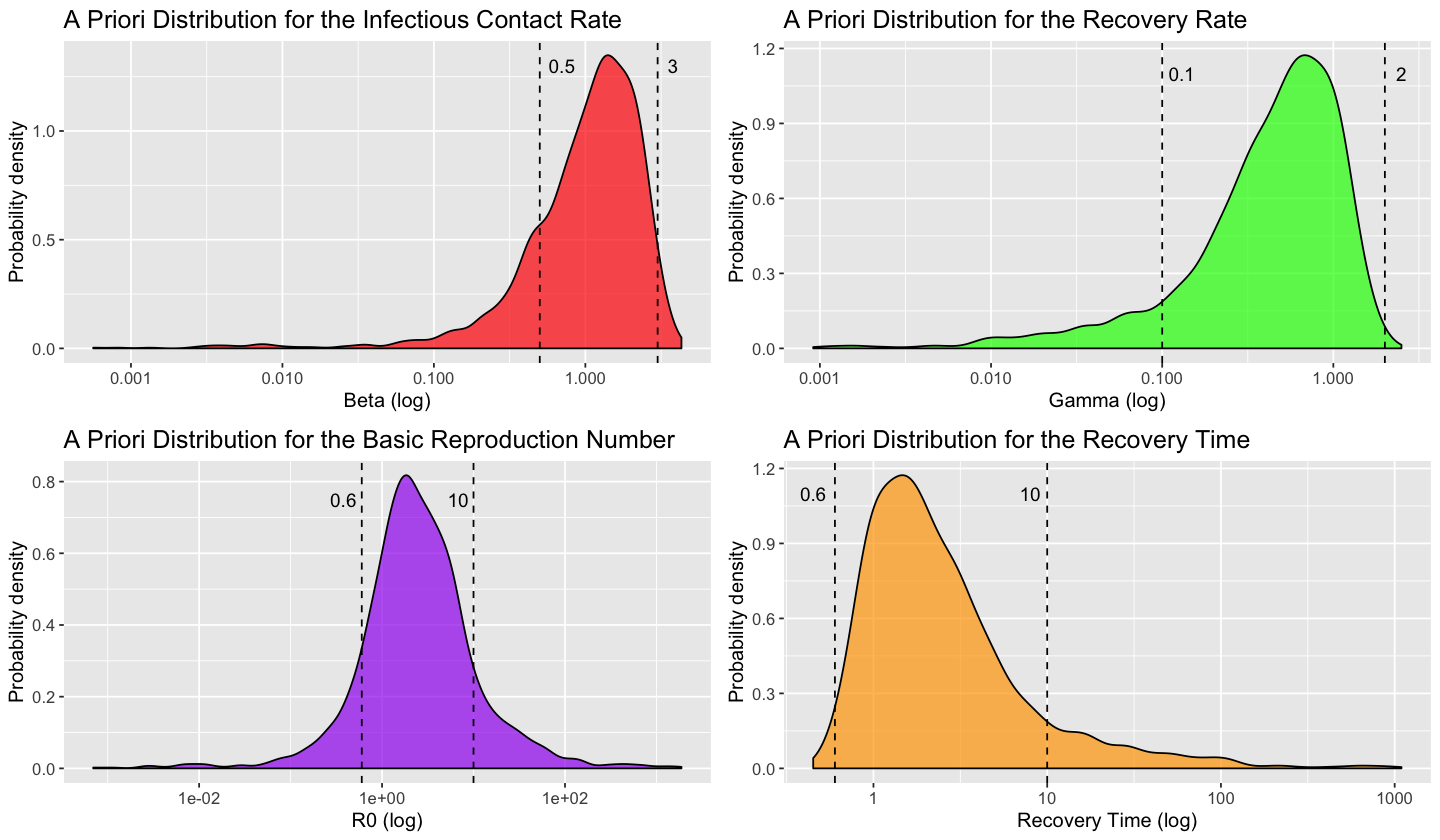

In [13]:
plot_beta <- ggplot(tibble(r = s_prior$beta)) + 
    geom_density(aes(x = r),fill="red", alpha = 0.7) + 
    geom_vline(xintercept = c(0.5, 3), color = "black",linetype=2) +
    annotate("text", x = 0.7, y = 1.3, label = "0.5", size=4, col = 'black') +  
    annotate("text", x = 3.8, y = 1.3, label = "3", size=4, col = 'black') +  
    scale_x_log10() +
    labs(x = "Beta (log)", y = "Probability density", title = "A Priori Distribution for the Infectious Contact Rate")+
    theme(axis.text=element_text(size=10), axis.title=element_text(size=12),
                 plot.title = element_text(size=15))

plot_gamma <- ggplot(tibble(r = s_prior$gamma)) + 
    geom_density(aes(x = r),fill="green", alpha = 0.7) + 
    geom_vline(xintercept = c(0.1, 2), color = "black",linetype=2) + 
    annotate("text", x = 0.13, y = 1.1, label = "0.1", size=4, col = 'black') +  
    annotate("text", x = 2.5, y = 1.1, label = "2", size=4, col = 'black') +  
    scale_x_log10() +
    labs(x = "Gamma (log)", y = "Probability density", title = "A Priori Distribution for the Recovery Rate")+
    theme(axis.text=element_text(size=10), axis.title=element_text(size=12),
                 plot.title = element_text(size=15))

plot_r0 <- ggplot(tibble(r = s_prior$R0)) + 
    geom_density(aes(x = r),fill="purple", alpha = 0.7) + 
    geom_vline(xintercept = c(0.6, 10), color = "black",linetype=2) + 
    annotate("text", x = 0.38, y = 0.75, label = "0.6", size=4, col = 'black') +  
    annotate("text", x = 6.8, y = 0.75, label = "10", size=4, col = 'black') +  
    scale_x_log10() +
    labs(x="R0 (log)",y="Probability density", title = "A Priori Distribution for the Basic Reproduction Number")+
    theme(axis.text=element_text(size=10), axis.title=element_text(size=12),
                 plot.title = element_text(size=15))

plot_rt <- ggplot(tibble(r = s_prior$recovery_time)) + 
    geom_density(aes(x = r),fill="orange", alpha = 0.7) + 
    geom_vline(xintercept = c(0.6, 10), color = "black", linetype=2) + 
    annotate("text", x = 0.45, y = 1.1, label = "0.6", size=4, col = 'black') +  
    annotate("text", x = 8, y = 1.1, label = "10", size=4, col = 'black') +  
    scale_x_log10() +
    labs(x="Recovery Time (log)", y = "Probability density", title = "A Priori Distribution for the Recovery Time")+
    theme(axis.text=element_text(size=10), axis.title=element_text(size=12),
                 plot.title = element_text(size=15))

grid.arrange(plot_beta, plot_gamma, plot_r0, plot_rt, nrow=2)

As we can see from the previous plots, all the priors are weakly informative, allowing for sensible values while excluding absurd values of the parameters.

### Checking Posteriors

We take one arbitrary sample from the prior distribution and check whether or not the model is able to retrieve the right parameters.

In [14]:
str(s_prior$pred_cases)

 num [1:2000, 1:25] 1 1 1 2 0 1 1 1 0 3 ...
 - attr(*, "dimnames")=List of 2
  ..$ iterations: NULL
  ..$           : NULL


In [15]:
# one arbitrary draw from the prior distribution
draw <- 16
# the number of predicted cases sampled from the prior distribution, which we will use as data
cases_simu <- s_prior$pred_cases[draw,]
data_simu <-  list (n_days = n_days, y0 = y0, t0 = t0, ts = t, N = N, cases = cases_simu)

In [16]:
fit_simu <- sampling(model, 
                     data = data_simu, 
                     chains = 2,
                     seed = 10, 
                     control = list(adapt_delta = 0.99))

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [17]:
params = c("beta", "gamma", "R0", "recovery_time")
paste("true beta:", toString(s_prior$beta[draw]), 
      ", true gamma:", toString(s_prior$gamma[draw]), ", true R0:", toString(s_prior$R0[draw]), 
      ", true recovery time:", toString(s_prior$recovery_time[draw]))

[1] "true beta: 0.418889126551727 , true gamma: 0.120576191779133 , true R0: 3.47406167312889 , true recovery time: 8.29351122509955"

In [18]:
print(fit_simu, pars = params)

Inference for Stan model: a7ea2dd895faed49ef182dd99acf41b0.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

              mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
beta          0.42    0.00 0.01 0.40 0.41 0.42 0.42  0.43   355    1
gamma         0.12    0.00 0.01 0.11 0.12 0.12 0.12  0.13   355    1
R0            3.46    0.01 0.11 3.28 3.38 3.45 3.52  3.70   372    1
recovery_time 8.27    0.02 0.38 7.64 8.01 8.25 8.49  9.09   328    1

Samples were drawn using NUTS(diag_e) at Fri Jun 18 15:26:12 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


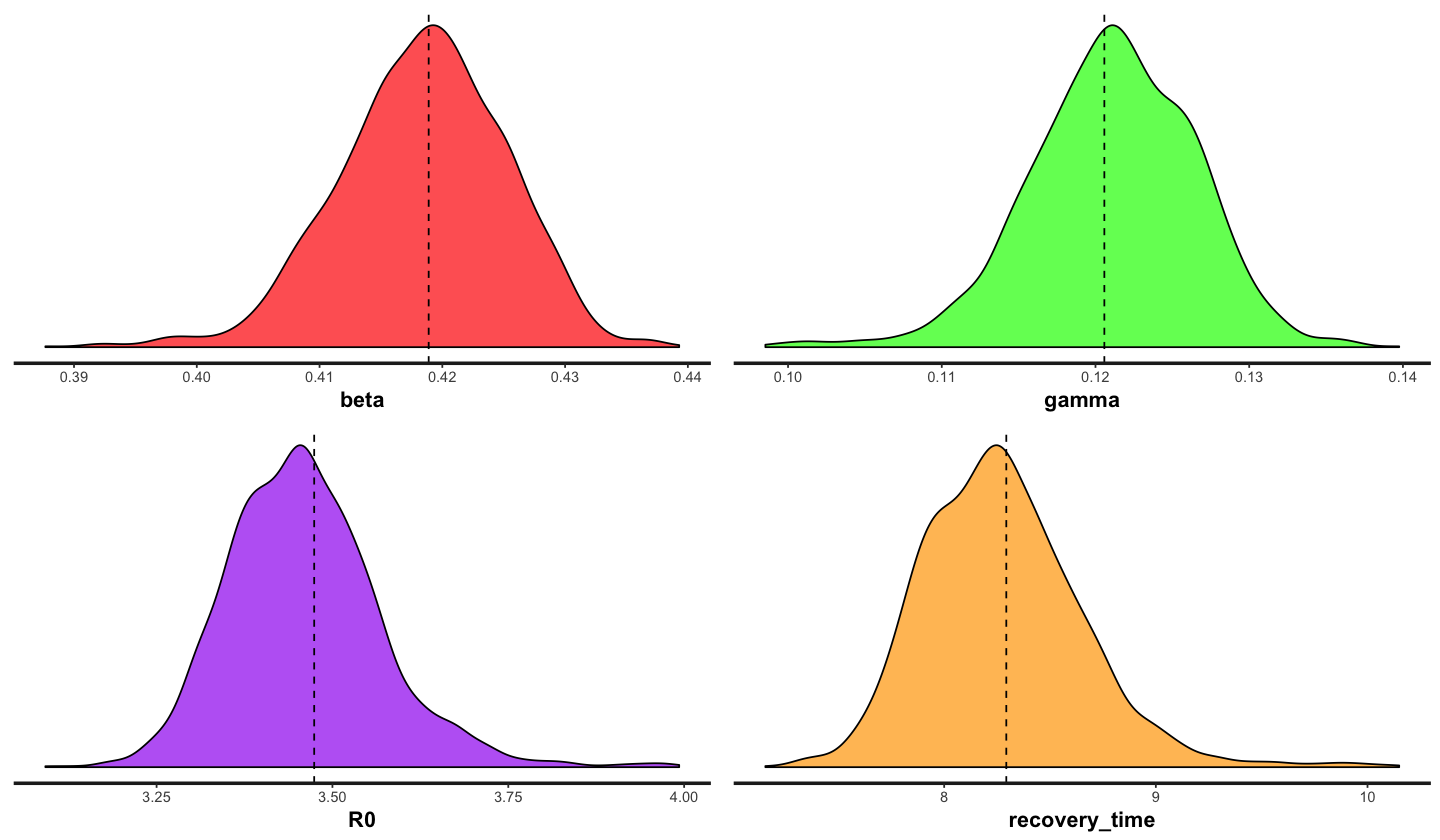

In [19]:
plot_beta <- stan_dens(fit_simu, pars="beta", fill = "red", alpha = 0.7) + geom_vline(xintercept =s_prior$beta[draw], linetype="dashed")
plot_gamma <- stan_dens(fit_simu, pars="gamma", fill = "green", alpha = 0.7) + geom_vline(xintercept = s_prior$gamma[draw], linetype="dashed")
plot_R0 <- stan_dens(fit_simu, pars="R0", fill = "purple", alpha = 0.7) + geom_vline(xintercept = s_prior$R0[draw], linetype="dashed")
plot_rt <- stan_dens(fit_simu, pars="recovery_time", fill = "orange", alpha = 0.7) + geom_vline(xintercept = s_prior$recovery_time[draw], linetype="dashed")
grid.arrange(plot_beta, plot_gamma, plot_R0, plot_rt, nrow=2)

### Let's start the inference

In [20]:
fit_sir_negbin <- sampling(model, 
                           data = data_sir,
                           iter = 6000,
                           warmup = 4000,
                           chains = 2,
                           control = list(adapt_delta = 0.99),
                           seed = 28)

Warning message:
“There were 23 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

A higher adapt_delta (default = 0.8) avoid chains from diverge. The downside is that sampling will tend to be slower because a smaller step size means that more steps are required. Since the validity of the estimates is not guaranteed if there are many post-warmup divergences, the slower sampling is a minor cost.

In [21]:
check_hmc_diagnostics(fit_sir_negbin)


Divergences:


23 of 4000 iterations ended with a divergence (0.575%).
Try increasing 'adapt_delta' to remove the divergences.



Tree depth:


0 of 4000 iterations saturated the maximum tree depth of 10.



Energy:


E-BFMI indicated no pathological behavior.


### Checking the inference
Let’s specify the parameters of interest.

In [22]:
pars=c('beta', 'gamma')

We start with a summary table of the results, which displays the posterior mean, standard error, quantiles, and some useful diagnostics.

The Gelman-Rubin ratio Rhat ($\hat{R}$) estimates the ratio between the overall variance and the within chain variance: if $\hat{R} \approx 1$, then all the Markov chains appear to be sampling from the same distribution; otherwise, they are not mixing and at least one of the chains is producing biased samples. 

To measure how “informative” the sampling procedure has been, we may use the effective sample size n_eff, which is typically smaller than the total number of sampling iterations. Samples from an MCMC procedure tend to be correlated, meaning there is redundant information in the samples which makes the posterior estimates less precise. 

Here we note that $\hat{R} = 1$ and that n_eff is large, which makes us confident we can rely on the inference.

In [23]:
print(fit_sir_negbin, pars = pars)

Inference for Stan model: a7ea2dd895faed49ef182dd99acf41b0.
2 chains, each with iter=6000; warmup=4000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

      mean se_mean   sd 2.5%  25% 50% 75% 97.5% n_eff Rhat
beta   0.9       0 0.01 0.89 0.89 0.9 0.9  0.91  1489    1
gamma  0.4       0 0.01 0.38 0.39 0.4 0.4  0.41  1531    1

Samples were drawn using NUTS(diag_e) at Fri Jun 18 15:29:57 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


We can furthermore plot the marginal posterior densities and confirm the Markov chains are in agreement with one another.

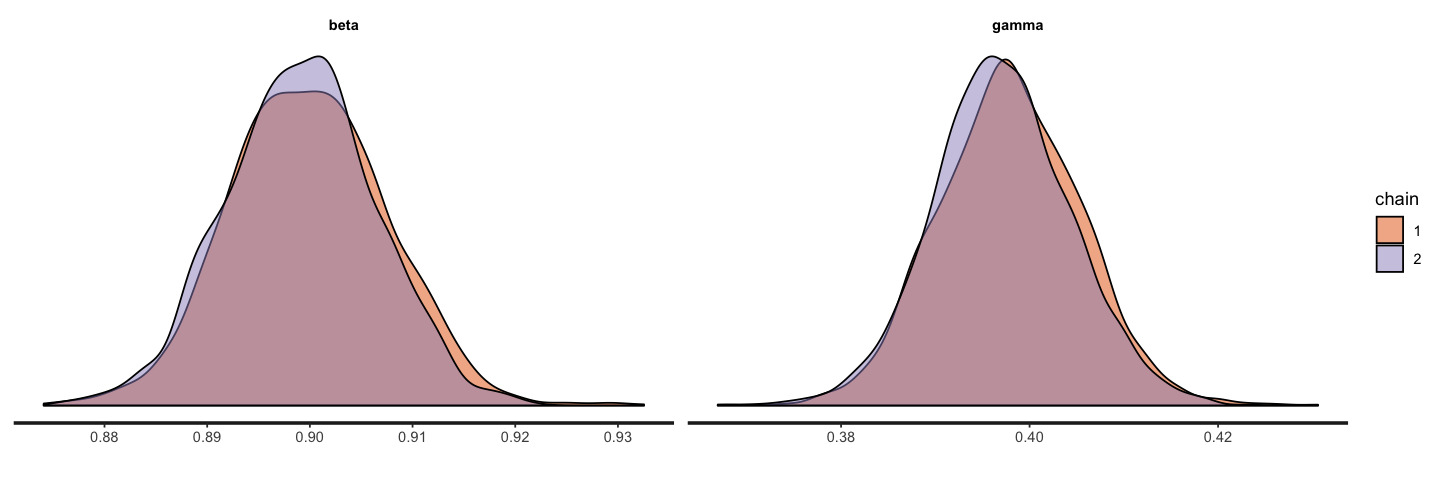

In [24]:
options(repr.plot.width=12, repr.plot.height=4)
stan_dens(fit_sir_negbin, pars = pars, separate_chains = TRUE)

### Checking the model
Now that we trust our inference, let us check the utility of our model. It is good to check if our model, once fitted, produces simulations that are consistent with the observed data. This is the idea behind posterior predictive checks.

We sample predictions from the posterior and use these samples to construct a fitted curve for infected people, together with the uncertainty (95% CI, meaning observed data is expected to fall outside of this interval one in twenty times). This posterior predictive check allows us to verify if the model captures the structure of the data. Here we see that the model gives a good fit to the data, and that the model uncertainty is able to capture the variation of the data.

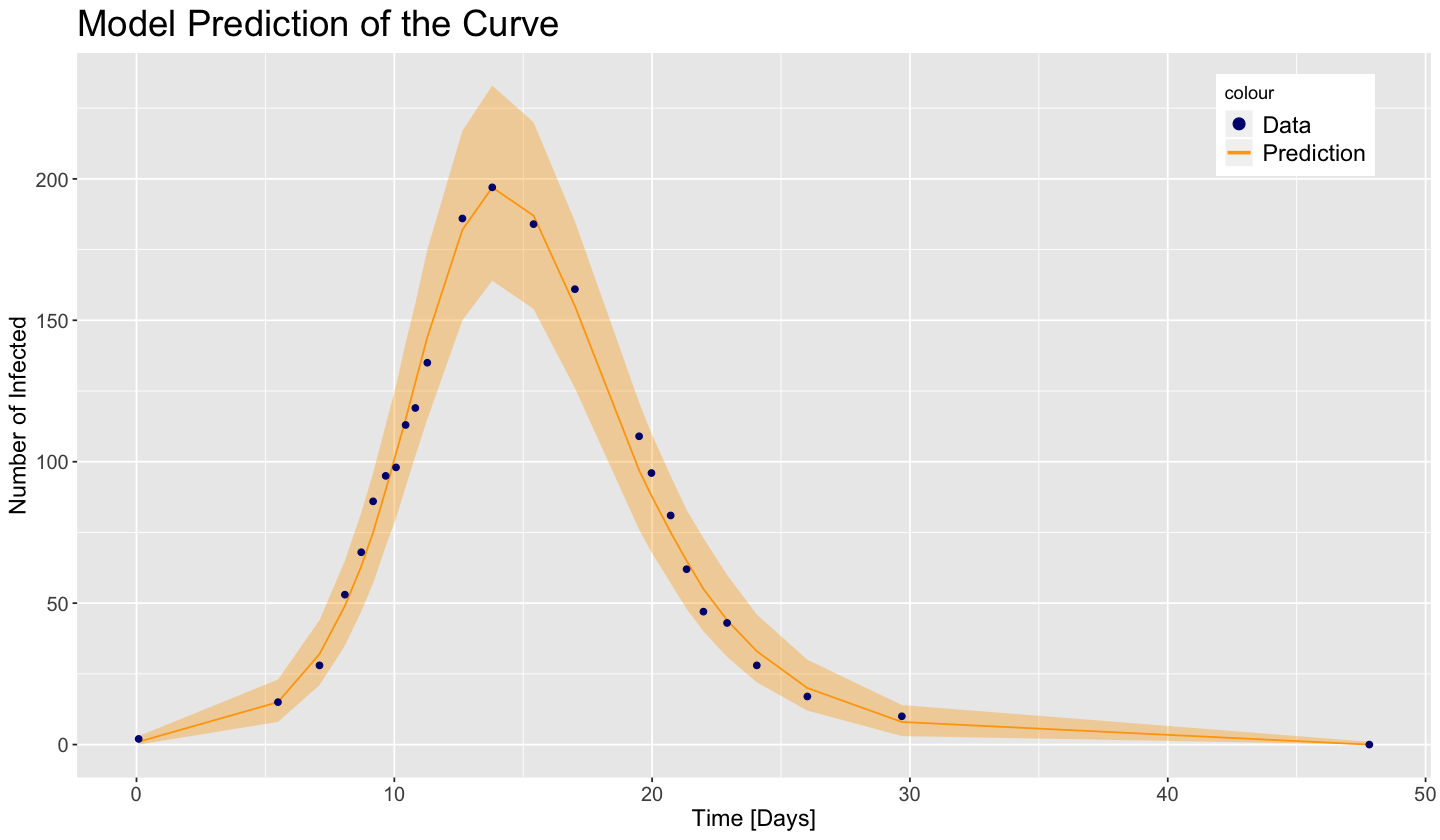

In [25]:
smr_pred <- cbind(as.data.frame(summary(
    fit_sir_negbin, pars = "pred_cases", probs = c(0.025, 0.5, 0.975))$summary), t, cases)
colnames(smr_pred) <- make.names(colnames(smr_pred)) # to remove % in the col names
# the make.names function makes syntactically valid names out of character vectors -> X2.5., X50., X97.5..
options(repr.plot.width=12, repr.plot.height=7)
ggplot(smr_pred, mapping = aes(x = t)) +
    geom_ribbon(aes(ymin = X2.5., ymax = X97.5.), fill = "orange", alpha = 0.35) +
    geom_line(mapping = aes(x = t, y = X50., color = "Prediction")) + 
    geom_point(mapping = aes(y = cases, color = 'Data')) +
    labs(x = "Time [Days]", y = "Number of Infected", title = "Model Prediction of the Curve") +
    scale_color_manual(values = c("Data" = "navy", "Prediction" = "orange"), 
                       guide = guide_legend(override.aes = list(linetype = c(0, 1),
                                            shape = c(19, NA), cex=c(3, 1))))+
    theme(axis.text=element_text(size=12), axis.title=element_text(size=14),
                 plot.title = element_text(size=22), legend.text = element_text(size=14),
                 legend.position = c(.9, .9))

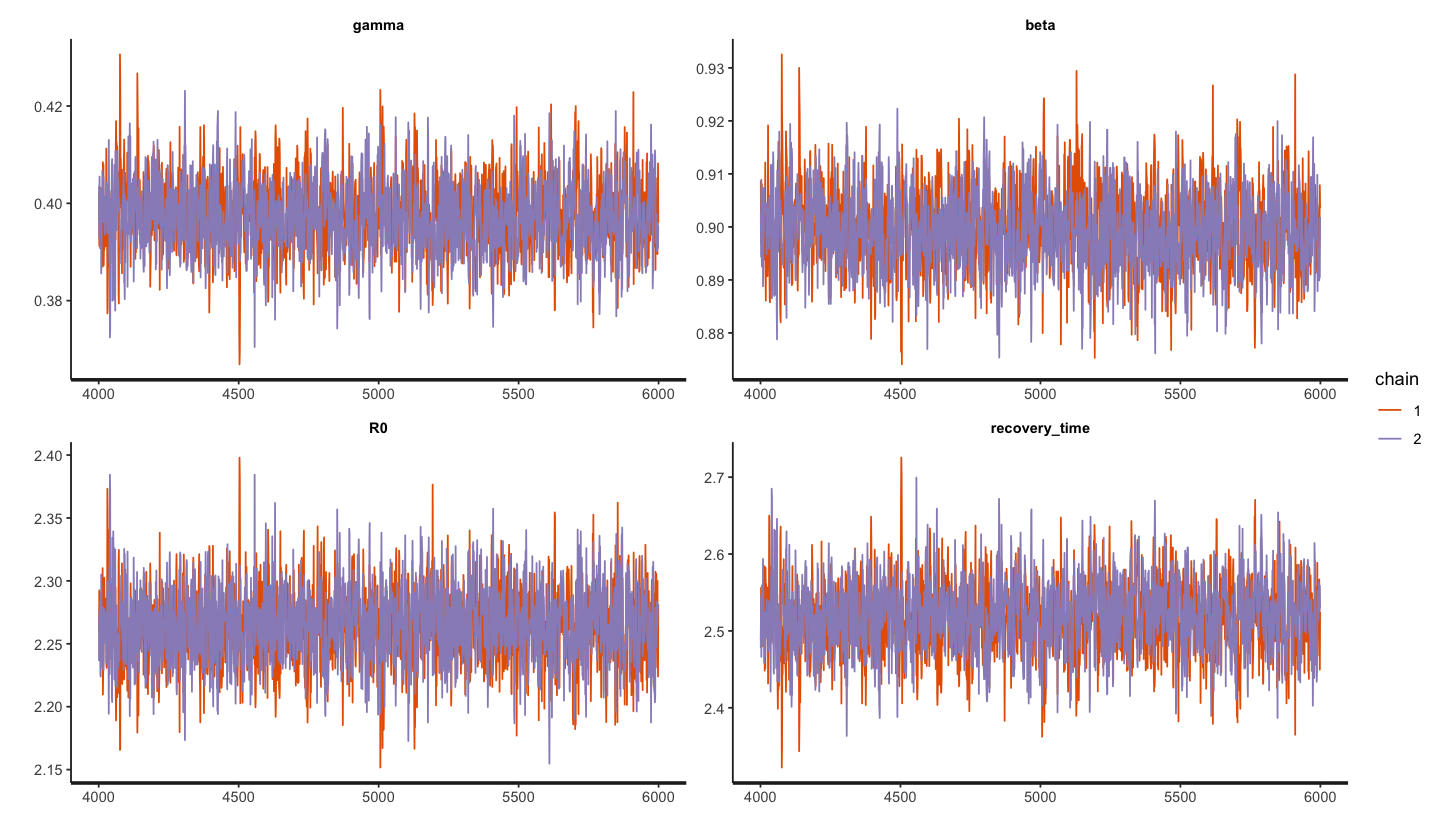

In [26]:
traceplot(fit_sir_negbin, pars = c("gamma", "beta", "R0", "recovery_time"), nrow=2)

### Is the model able to retrieve the right parameters?

Here we compare the estimation of the parameters of interest with the values passed to gillespie function.
The vertical dotted lines represent the true value of the parameters passed to the Gillespie function.

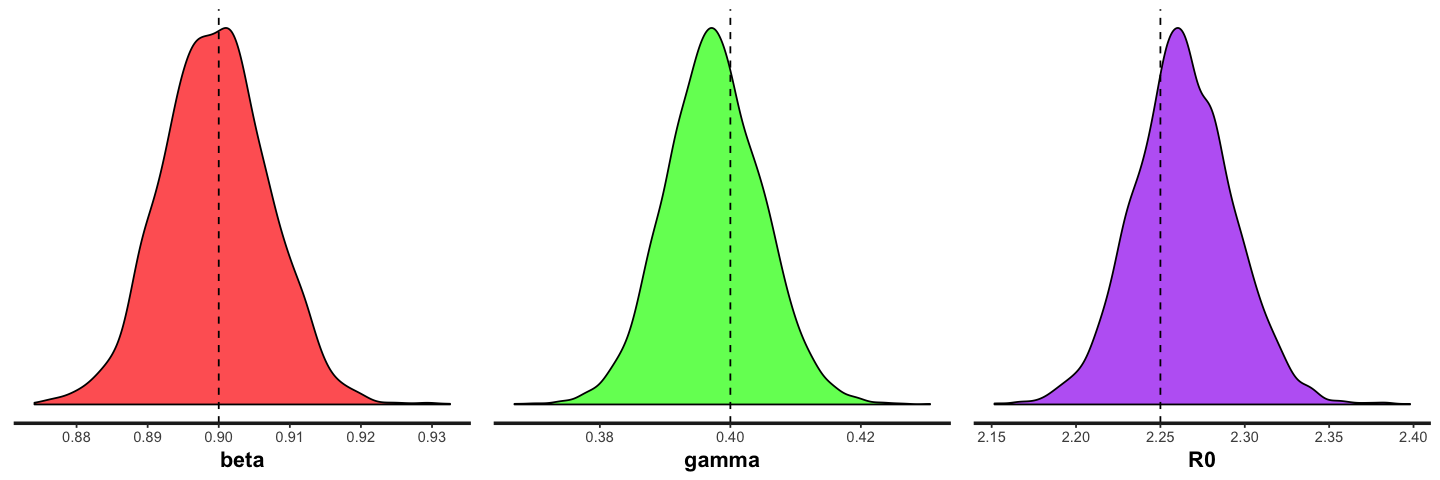

In [27]:
options(repr.plot.width=12, repr.plot.height=4)

plot_beta <- stan_dens(fit_sir_negbin, pars="beta", fill = "red", alpha = 0.7) + 
                       geom_vline(xintercept = beta, linetype="dashed")

plot_gamma <- stan_dens(fit_sir_negbin, pars="gamma", fill = "green", alpha = 0.7) + 
                        geom_vline(xintercept = gamma, linetype="dashed")

plot_r0 <- stan_dens(fit_sir_negbin, pars="R0", fill = "purple", alpha = 0.7) + 
                     geom_vline(xintercept = beta/gamma, linetype="dashed")

grid.arrange(plot_beta, plot_gamma, plot_r0, nrow=1)

### Comparing with precise SIR data

Here we superimpose the deterministic SIR curve (see [3]) generated with the parameters found by the inference process over the gillespie trajectory. We can check that the fit is very good.

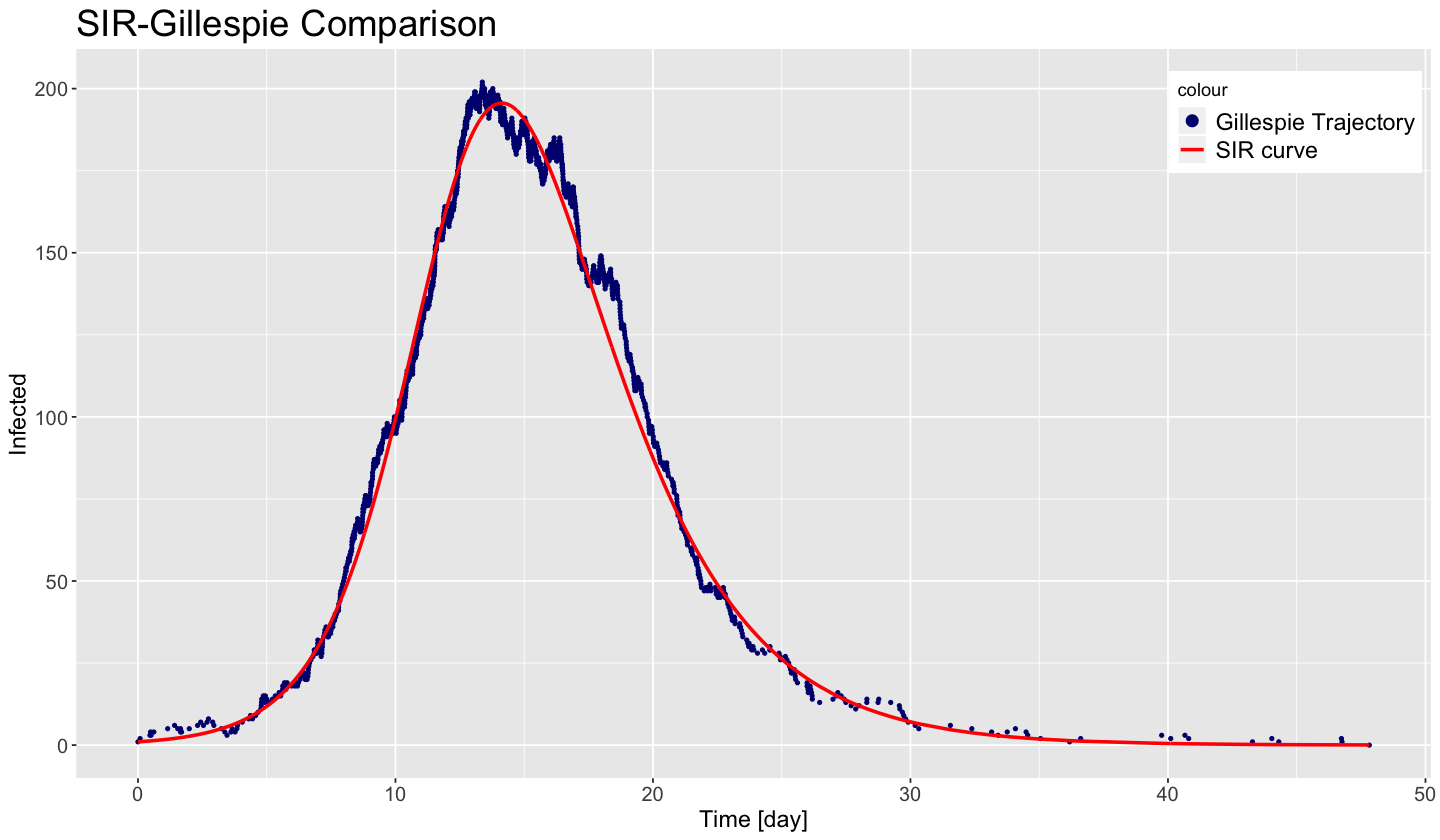

In [46]:
# Parameters and initial conditions
parameters <- c(beta = 0.9, gamma = 0.4)
initials <- c(S = 999/1000, I = 1/1000, R = 0) # The SIR function accepts only S+I+R = 1

# Solve and plot
sir <- SIR(pars = parameters, init = initials, time = Xmatt$t)

options(repr.plot.width=12, repr.plot.height=7)
ggplot() + geom_point(data=Xmatt, aes(x=t, y=I, color = 'Gillespie Trajectory'),  cex=0.8) +
           geom_line(data=sir$results,  aes(x=time, y=I*1000, color='SIR curve'), lwd = 1) +
           labs(title = "SIR-Gillespie Comparison", x = "Time [day]", y = "Infected") +
           scale_color_manual(values = c("Gillespie Trajectory" = "navy", "SIR curve" = "red"), 
                              guide = guide_legend(override.aes = list(linetype = c(0, 1),
                                                                  shape = c(19, NA), cex=c(3, 1))))+
           theme(axis.text=element_text(size=12), axis.title=element_text(size=14),
                 plot.title = element_text(size=22), legend.text = element_text(size=14),
                 legend.position = c(.9, .9))

### Conclusions
From what we have seen up to now, we are able to perform a good inference on a simple SIR model. But what happen when we move from "artificial" data to real world data? This is left to the next section.

## SIR with Under-reporting
### Application on COVID-19 Wuhan Outbreak
In this section we will work on the SIR model jointly with the problem of under-reporting.  
Due to the limited capabilites on diagnositc COVID-19, we can immagine that the number of real infectous are much more respect that ones reported and confirmed by public healt agencies. So, respect the usual SIR model, we will introduce the so called ascertainment rate $ASC$, that tells us how many infections we don’t know compared with those we do know about (see [0]).  

Moreover it's reasonable that there is a time in between when a case is reported and when a people becomes actually infectous, a piece of the puzzle that we have to keep in mind.

The dataset available from the link below, is composed by 7 columns:

Time | Province | City | Cum_Confirm | Cum_Heal  |  Cum_Dead | Suspected 
-----|----------|------|-------|-----------|-----------|----------
2019-12-01| Hubei| Wuhan | 1 | 0 | 0 | 0
... | ... | ... | ... | ... | ... | ...
2020-03-09| Hubei| Wuhan | 49948 | 30985 | 2389 | 0

We won't use the data before January 1, because the epidemic data are poor and model an epidemic at that stage it's very difficult and challenging.

In [2]:
#---IMPORT DATA---

githubURL <- "https://github.com/thlytras/nCoVasc/blob/master/dat.RData?raw=true"
load(url(githubURL))   #Load Dataset
options(repr.plot.width = 12, repr.plot.height = 7)   #Dimension Plot


In [3]:
#---PREPARE DATASET---

dates  <- seq.Date(as.Date("2019-12-31"), wuhan$time[nrow(wuhan)], by="day")   #Generate sequence of Dates
dat0   <- data.frame(time=dates)
dat0   <- merge(dat0, wuhan, all.x=TRUE)    #Wuhan dataframe is imported in the workspace, when we load the dataset
dat0$rep <- c(NA, diff(dat0$cum_confirm))   #Calculate the new cases x day
dat0 <- dat0[-1, c("time","rep")]
dat  <- dat0
rownames(dat) <- NULL   #Drop the indices
head(dat)

time       rep
1 2020-01-01 3  
2 2020-01-02 1  
3 2020-01-03 0  
4 2020-01-04 0  
5 2020-01-05 0  
6 2020-01-06 0

### Cases Definition
On February 12 there was a spike of 13436 retroactively reported confirmed cases due to a change in the case definition (see [1]). We addressed this by linearly interpolating the new confirmed cases for that date and distributing the remainder to all previous dates in proportion to the number of cases already reported.

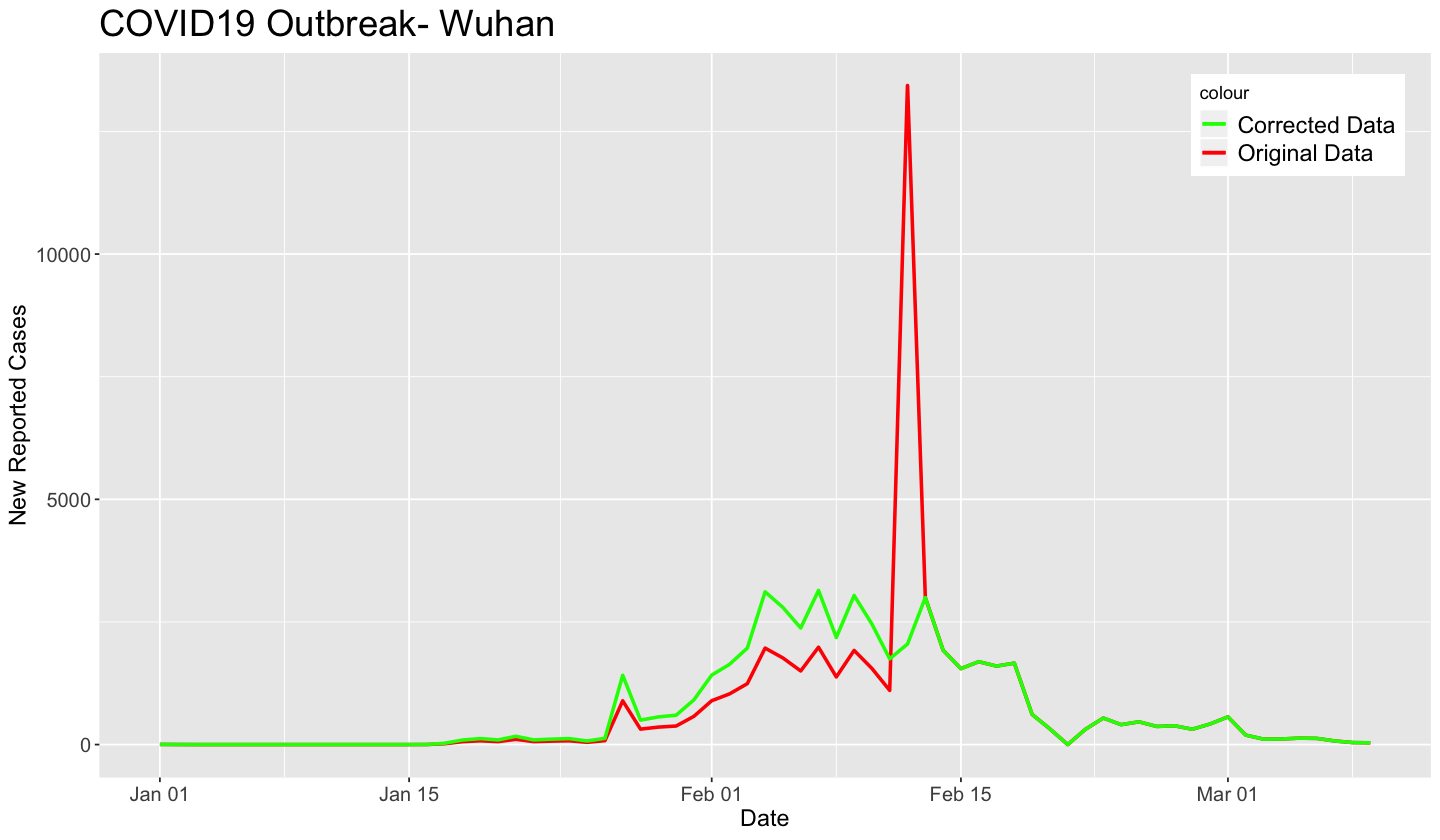

In [4]:
#---OUTLIER---

index_max  <- which(dat$rep==max(dat$rep))   #Find the peak
index_max1 <- index_max-1
mean_v     <- dat$rep[c(index_max1, index_max+1)] %>% mean() %>% round()   #Linear interpolation
divid_inf  <- (dat$rep[1:index_max1]/sum(dat$rep[1:index_max1])*(dat$rep[index_max]-mean_v)) %>% round()   #Redistribution 

dat$rep0 <- dat0$rep   #New dataset that we will use (dat)
dat$rep[1:index_max1] <- dat$rep[1:index_max1] + divid_inf
dat$rep[index_max]    <- mean_v

ggplot() + geom_line(data=dat, aes(x=time, y=rep0, color='Original Data'),  size=1) +
           geom_line(data=dat, aes(x=time, y=rep,  color='Corrected Data'), size=1) +
           labs(title="COVID19 Outbreak- Wuhan", x="Date", y="New Reported Cases") +
           scale_color_manual(values = c("Original Data"="red", "Corrected Data"="green")) +
           theme(axis.text  = element_text(size=12), axis.title  = element_text(size=14),
                 plot.title = element_text(size=22), legend.text = element_text(size=14),
                 legend.position = c(0.9, 0.9))

### Retrieve Infectous People 

In literature the time between case infection and case confirmation/reporting is modelled with a Weibull distribution.
As reported in the WHO-China joint mission report, the Wuhan case can be modeled with a $\text{Weidbull}(k,\lambda)$ distribution with parameters of $(k=4.4,\lambda=22.3)$ on January 10, decreasing linearly to $(k=2.6,\lambda=12.1)$ on February 10 and after. (see [2])

This means that there was an increased capability on find new infected, because the most probable time between reporting and infection becomes smaller, i.e they are quickly reported and moreover the pdf becomes sharper as could be seen in the next plot.

* **Why we should use a Weidbull distribution?**

    The 2-parameters Weidbull distribution is first of all very flexbile and used a lot in completely different problems and secondly the distribution of survival times can be well approximated by it. In this case the survival time can be seen as the time that a "infected person have" until is discovered and reported.

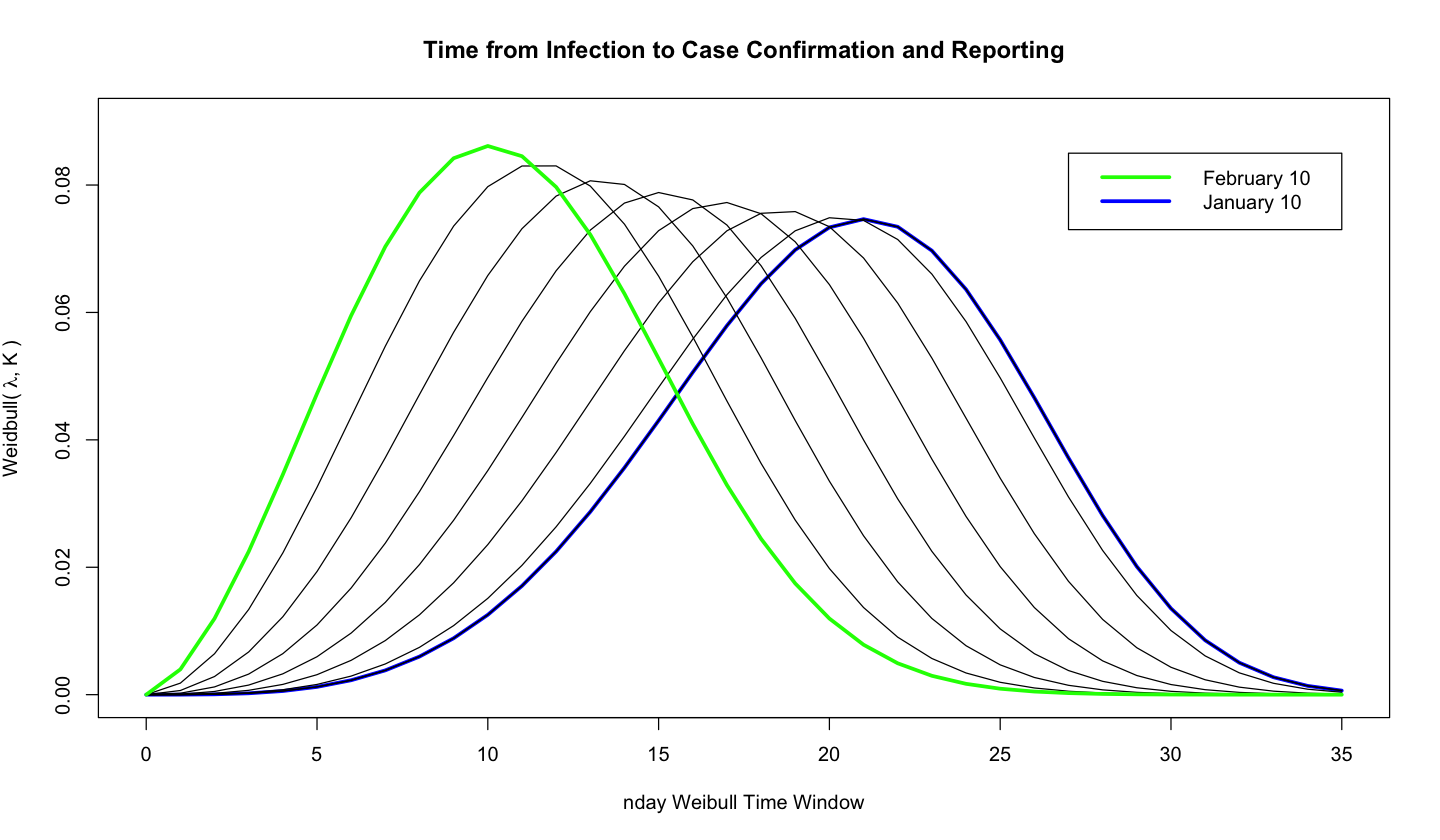

In [5]:
#---TIMES INFECTIONS---

init_days <- (as.POSIXlt("2020-01-10")-as.POSIXlt(dat$time[1]) )   %>% as.numeric(units="days") %>% round()   #Days  1/1- 9/1
weid_days <- (as.POSIXlt("2020-02-10")-as.POSIXlt("2020-01-10")+1) %>% as.numeric(units="days") %>% round()   #Days 10/1-10/2

shapeW <- c(rep(4.4,  init_days), seq(4.4,   2.6, length.out=weid_days), rep(2.6,  nrow(dat)-weid_days-init_days))
scaleW <- c(rep(22.3, init_days), seq(22.3, 12.1, length.out=weid_days), rep(12.1, nrow(dat)-weid_days-init_days))

nday <- 35   #Time Window for Weidbull distribution
cut_rowinit <- 1   #Init data that could be cut (1=None)

infect_times <- function(i) 
{return(dweibull(nday:0, shape=shapeW[i], scale=scaleW[i]) )}  #vector length: nday+1

plot(nday:0, infect_times(1), type="l", ylim=c(0,0.09), col="blue", lwd=3,
     xlab="nday Weibull Time Window", ylab=expression(paste("Weidbull( ",lambda,", K )")))
title(main="Time from Infection to Case Confirmation and Reporting")
for (i in seq(2,nrow(dat)-1,5))
{lines(nday:0, infect_times(i), col="black")}
lines(nday:0, infect_times(nrow(dat)), col="green",lwd=3)
legend(legend = c("February 10", "January 10"), col = c("green","blue"), lty=c(1,1), lwd=c(3,3), 
       cex = 1, text.col = "black", horiz = F, x = c(27, 35), y = c(0.073, 0.085))

The idea now is the following: we start at January 1 and the question is ***How many new infectous are there?*** In order to answer this question we should look $n_{day}$ in the future and look at how many cases are reported. 

`Accorindlgy to the Weidbull distribution each day in the future has a probability that a fraction of the reported cases at that day is due to infectous at January 1. Actually we have to invert the problem and given reported cases distribute them in the past.`

Obviously due to the fact that the dataset is limited we will cut some final days, because the infected people are not well estimated, but the choice of the cut is arbitrary; we've seen that trim the last 15 days works fine for our data.

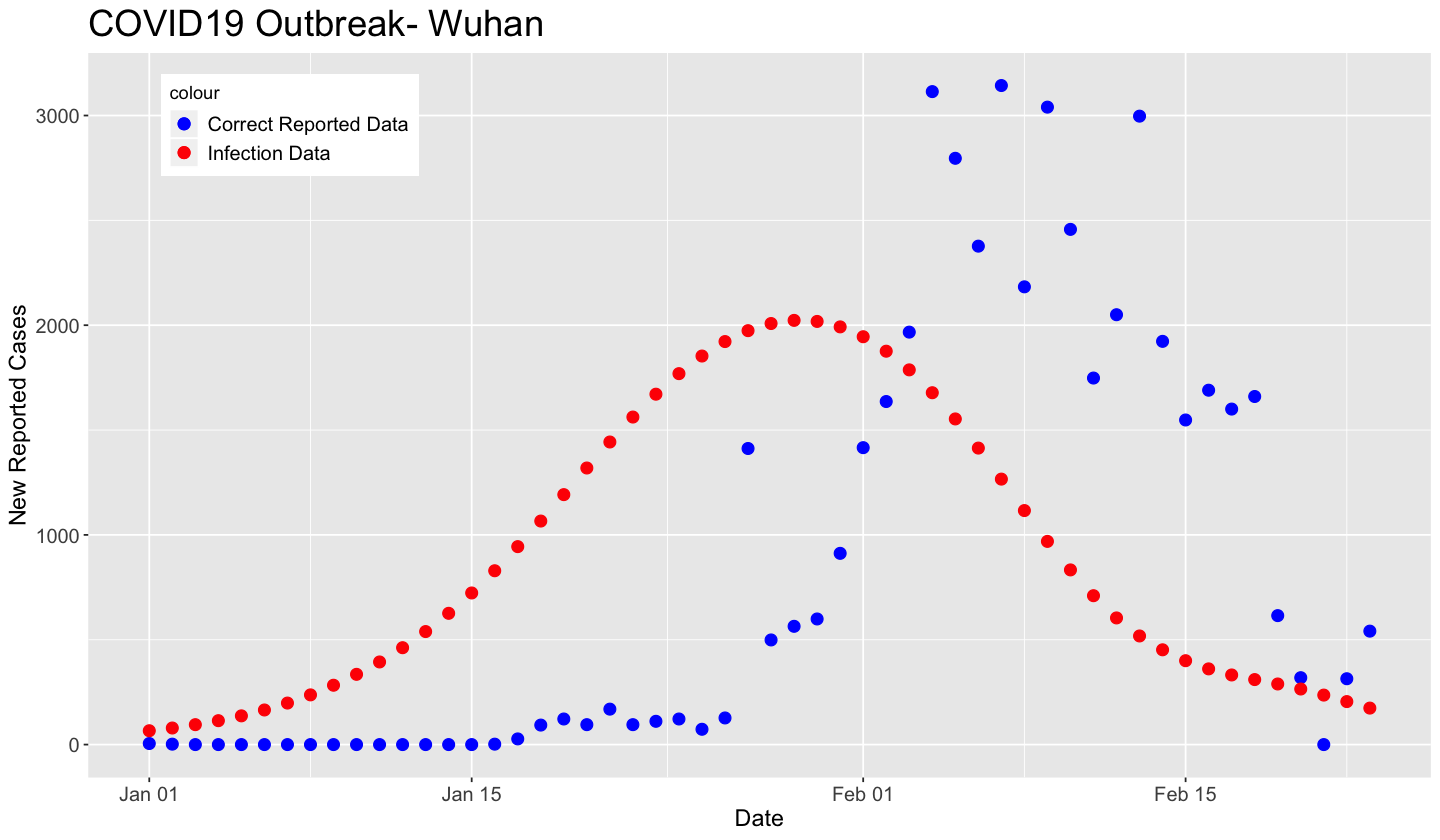

In [6]:
#---INFECTION DATA---
#(never re-run this cell alone)

Infect_times <- function(i){   #Create the moving Weidbull, with a fixed window of nday
  propInf <- dweibull(nday:0, shape=shapeW[i], scale=scaleW[i])   #Reverted pdf         
  vectInf <- c(rep(0,i-1), propInf, rep(0, nrow(dat)-cut_rowinit+1-i+1)) #the length of vectInf = nrow+nday
  return(vectInf)}

M23 <- sapply(seq(1, nrow(dat)), Infect_times)   #Create nrow moving Weidbull distribution
M2  <- M23[-(1:(nday-cut_rowinit+1)), ] #

datrep  <- matrix(dat$rep[cut_rowinit:nrow(dat)], nrow=(nrow(dat)-cut_rowinit+1), ncol=1)   #Convert dat$rep to matrix
dat$exp <- (M2 %*% datrep)[1:nrow(dat)]   #Lose the dim of the matrix
dat$exp <- (dat$exp * sum(dat$rep)/sum(dat$exp)) %>% round()   #We have to renormalize repsect the actual reported

cut_rowend  <- 15 
dat <- dat[1:(nrow(dat)-cut_rowend),]   #Trim last days 

ggplot() + geom_point(data=dat, aes(x=time, y=rep, color='Correct Reported Data'), size=3) +
           geom_point(data=dat, aes(x=time, y=exp, color='Infection Data'), size=3) +
           labs(title="COVID19 Outbreak- Wuhan", x="Date", y="New Reported Cases") +
           scale_color_manual(values = c("Correct Reported Data"="blue","Infection Data"="red")) +
           theme(axis.text  = element_text(size=12), axis.title  = element_text(size=14),
                 plot.title = element_text(size=22), legend.text = element_text(size=12),
                 legend.position = c(0.15, 0.9))

### JAGS Model
Now that we have data on infectous people, we can simulate via MCMC our model. Notice that what we've found so far, is actually $\Delta I(t)$ the new cases every day, i.e the increment that can be found if one solve the ODEs of the SIR model (obvioulsy we are assuming that Wuhan's epidemic can be described by a SIR model).

We assume that cases are observed from only a fraction of the population (i.e. the ascertainment rate) that is stable over time. We further assumed that cases are isolated upon confirmation and are thus removed from the “Infected” pool at that time (see [2]); so we don't care if the infected people after been removed actually heals or not.

In [7]:
#---JAGS MODEL---

N <- 11000000

datJ <- list(
  N  = N,         # Wuhan population (approximately)
  TT = nrow(dat), # Timepoints in the data
  dI = dat$exp,   # New infections (estimated before)
  dR = dat$rep)   # New removals (not infectious anymore) (in italiano infectious = infettivo, non infetto) 

model_string <- 
"model {
        I[1] <- round(dI[1]/asc)
        R[1] <- round(dR[1]/asc)
        S[1] <- N - I[1] - R[1]

        for (t in 2:TT) 
        {
          dI[t] ~ dbin(pSI[t], round(S[t-1]*asc))  
          pSI[t] <- 1-exp(-beta*I[t-1]/N)

          dR[t] ~ dbin(pIR[t], round(I[t-1]*asc)) 
          pIR[t] <- 1-exp(-gamma)

          I[t] <- I[t-1] + round(dI[t]/asc) - round(dR[t]/asc) 
          R[t] <- R[t-1] + round(dR[t]/asc)
          S[t] <- N - I[t] - R[t]
        }

        beta  ~ dunif(0,1)
        gamma ~ dunif(0,1)
        asc   ~ dunif(0,1)
        R0       <- beta/gamma
        rec_time <- 1/gamma
      }"

In the model definition above some points are misterious, so now we try to make things more clear.

* **Why we've used Binomials pdf?**  
    Assume we have $I$ infectous, $R$ removed and so $S=N-I-R$ at time $t$. The probability that no one becomes infectous is (see [3]):

    $$(1-p_{\beta})^{S(t)\frac{I(t)}{N}}=\bigl[(1-p_{\beta})^{\frac{I(t)}{N}}\bigr]^{S(t)}=\bigl[1-p_{\beta}(I(t))\bigr]^{S(t)}$$
    
  where $p_{\beta}$ is the probability that someone takes the illness independent by $I(t)$. So the probability density of the   new infectous $dI$ at time $t$ will be the binomial one (see [4]):
  
  $$P(dI|p_{\beta}(I),S)= {S\choose dI} \times [p_{\beta}(I)]^{dI} \times [1-p_{\beta}(I)]^{S-dI}$$

    where in our JAGS model $p_{\beta}\bigl(I(t)\bigr)=p_{SI}[t]dt$, where $dt=1\text{days}$.
    
  
* **What are $p_{SI}[t]$ and $p_{IR}[t]$?**  
   In the SIR model $p_{IR}[t]$ and $p_{SI}[t]$ are the transition probabilities at time $t$ between $S\rightarrow I$ and $I \rightarrow R$. A       physical interpretation can be found in the corresponding Taylor expansion:
   
   $$p_{SI}[t]=1-e^{~-\beta\frac{I(t)}{N}} \overset{N \gg I(t)}{\approx} \beta\frac{I(t)}{N}$$
   
   Analogous considerations could be done respect $dR$.


* **What is $ASC$ and why it enters in such way?**  
    $ASC$ by definition is `the ratio of detected cases to the true number of cases` (see [1]). So if $ASC \rightarrow 1$ then  there is no under-reporting, because the detected cases are the actual ones and we recover the usual SIR equations. Moreover:
    * Inside the SIR equations at the end of the code we have $\div ASC$ because we believe that both infected and recovered are much more respect what we have. If we have more infectous because underrepoting then we have also more recovered people.
    * Inside the bernoulli lines of code instead we have $\times ASC$, because if we have more infected, the pool of suscettible contains less individuals (the anologous holds for $dR$).

In [8]:
#---JAGS COMPILE and SAVING---

n_chains <- 6
n_iter <- 5000
v_init <- list("beta"=0.14, "gamma"=1/14, "asc"=0.5)   #Initial parameters of the chains (from typical params of COVID19)

model  <- jags.model(file = textConnection(model_string), data = datJ,
                     n.chains = n_chains, n.adapt = 5000, inits=v_init)
quants <- c("beta", "gamma", "asc","rec_time", "R0", "I", "R")   #quantities that we care about

res    <- coda.samples(model, var=quants, n.iter=n_iter, thin = 1) 

var <- res[, c(
  grep("beta",     varnames(res)), 
  grep("gamma",    varnames(res)),
  grep("asc",      varnames(res)),
  grep("rec_time", varnames(res)), 
  grep("R0",       varnames(res)) )]   #Take what we care from che MCMC object

summ <- summary(var)   #Summary statistics of the quantities

val_chain <- data.frame(beta_chain     = unlist(res[,"beta"]),
                        gamma_chain    = unlist(res[, "gamma"]),
                        asc_chain      = unlist(res[, "asc"]),
                        rec_time_chain = unlist(res[, "rec_time"]),
                        R0_chain       = unlist(res[, "R0"]))   #put the chains in a dataframe

val_chain$n_iter <- seq(1,n_iter*n_chains)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 106
   Unobserved stochastic nodes: 3
   Total graph size: 994

Initializing model



### Results

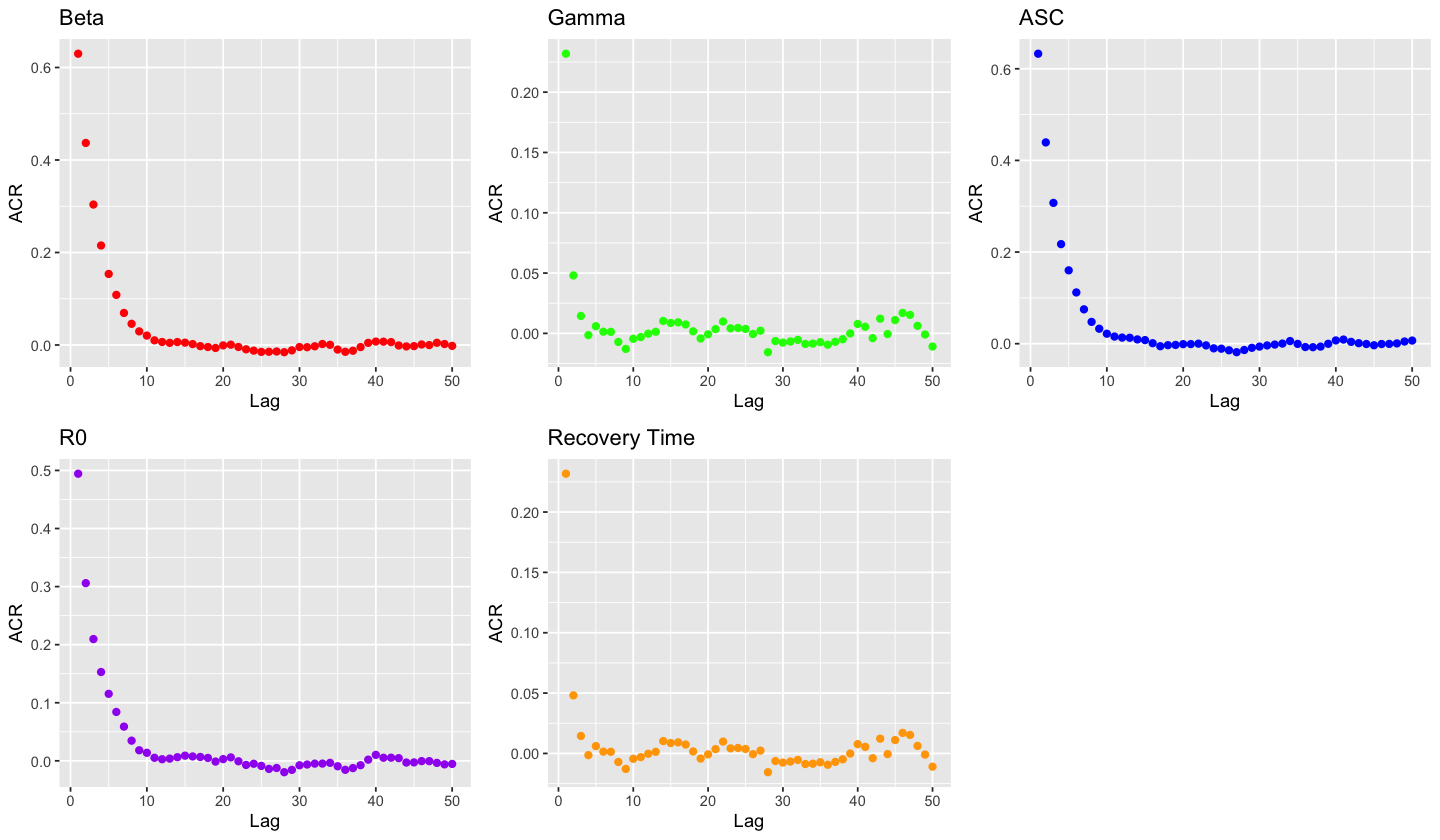

In [9]:
#---AUTOCORRELATION---

lags <- seq(1:50)
ACRs <- as.data.frame(autocorr.diag(var, lags=lags))

gp1 <- ggplot(data=ACRs, aes(x=lags, y=beta))     + geom_point(size=2, shape=16, color="red")     +
  labs(title="Beta",x="Lag",y="ACR")
gp2 <- ggplot(data=ACRs, aes(x=lags, y=gamma))    + geom_point(size=2, shape=16, color="green")   +
  labs(title="Gamma",x="Lag",y="ACR")
gp3 <- ggplot( data=ACRs, aes(x=lags, y=asc))     + geom_point(size=2, shape=16, color="blue")    +
  labs(title="ASC",x="Lag",y="ACR")
gp4 <- ggplot(data=ACRs, aes(x=lags, y=R0))       + geom_point(size=2, shape=16, colour="purple") +
  labs(title="R0",x="Lag",y="ACR")
gp5 <- ggplot(data=ACRs, aes(x=lags, y=rec_time)) + geom_point(size=2, shape=16, colour="orange") +
  labs(title="Recovery Time",x="Lag",y="ACR")

grid.arrange(gp1,gp2,gp3,gp4,gp5, ncol=3, nrow=2)

The plot above suggests to change the thinning, we could set for example $\text{thin} \geq 10$.  
Moreover we can inspect the variuos chains.

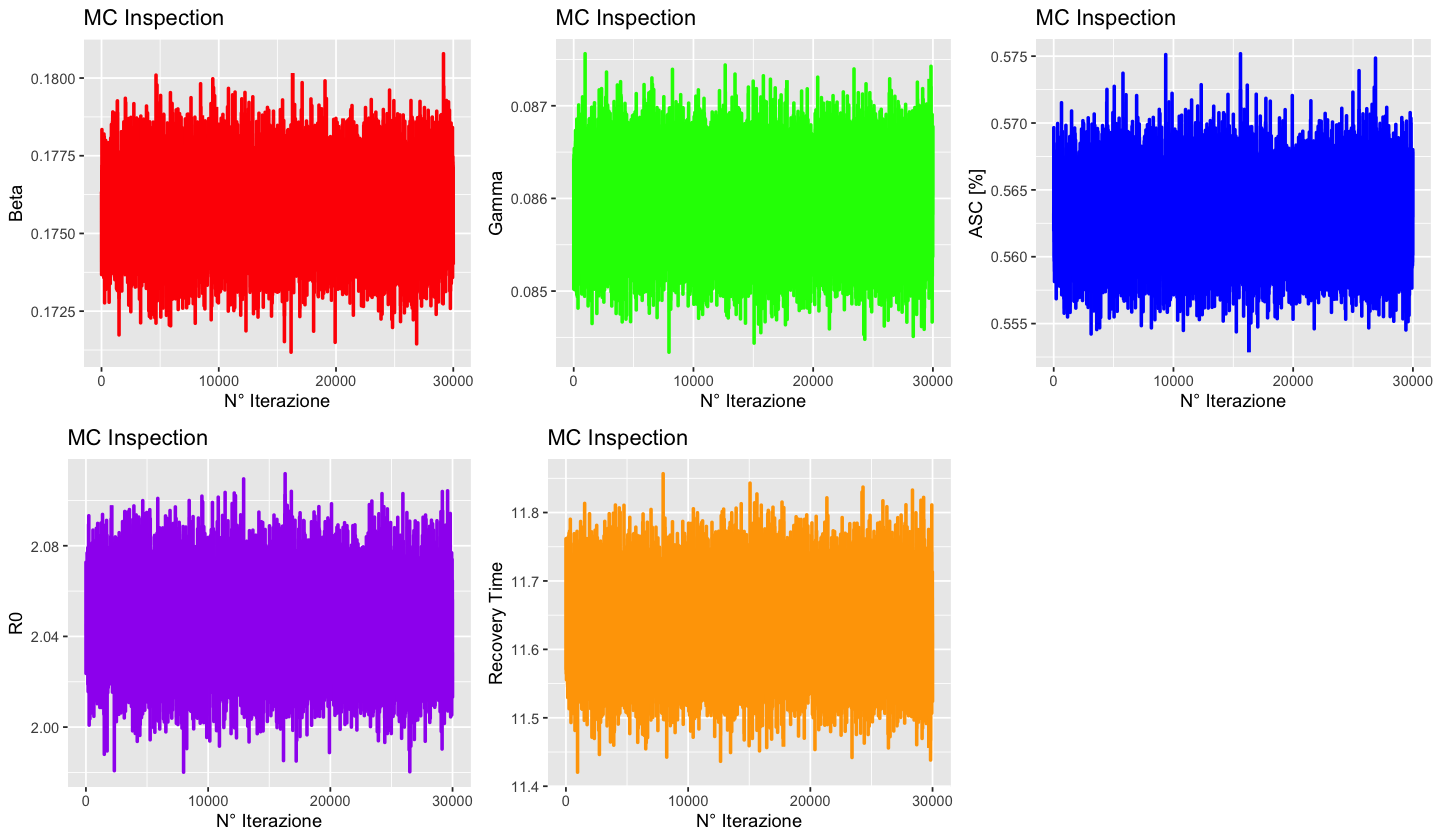

In [10]:
#---CHAINS---

gp1 <- ggplot()+ geom_line( data=val_chain, aes(x=n_iter, y=beta_chain),     color="red",    size=1) +
       labs(title="MC Inspection",x="N° Iterazione",y="Beta")
gp2 <- ggplot()+ geom_line( data=val_chain, aes(x=n_iter, y=gamma_chain),    color="green",  size=1) +
       labs(title="MC Inspection",x="N° Iterazione",y="Gamma")
gp3 <- ggplot()+ geom_line( data=val_chain, aes(x=n_iter, y=asc_chain*100),  color="blue",   size=1) +
       labs(title="MC Inspection",x="N° Iterazione",y="ASC [%]")
gp4 <- ggplot()+ geom_line( data=val_chain, aes(x=n_iter, y=R0_chain),       color="purple", size=1) +
       labs(title="MC Inspection",x="N° Iterazione",y="R0")
gp5 <- ggplot()+ geom_line( data=val_chain, aes(x=n_iter, y=rec_time_chain), color="orange", size=1) +
       labs(title="MC Inspection",x="N° Iterazione",y="Recovery Time")

grid.arrange(gp1,gp2,gp3,gp4,gp5, ncol=3, nrow=2)

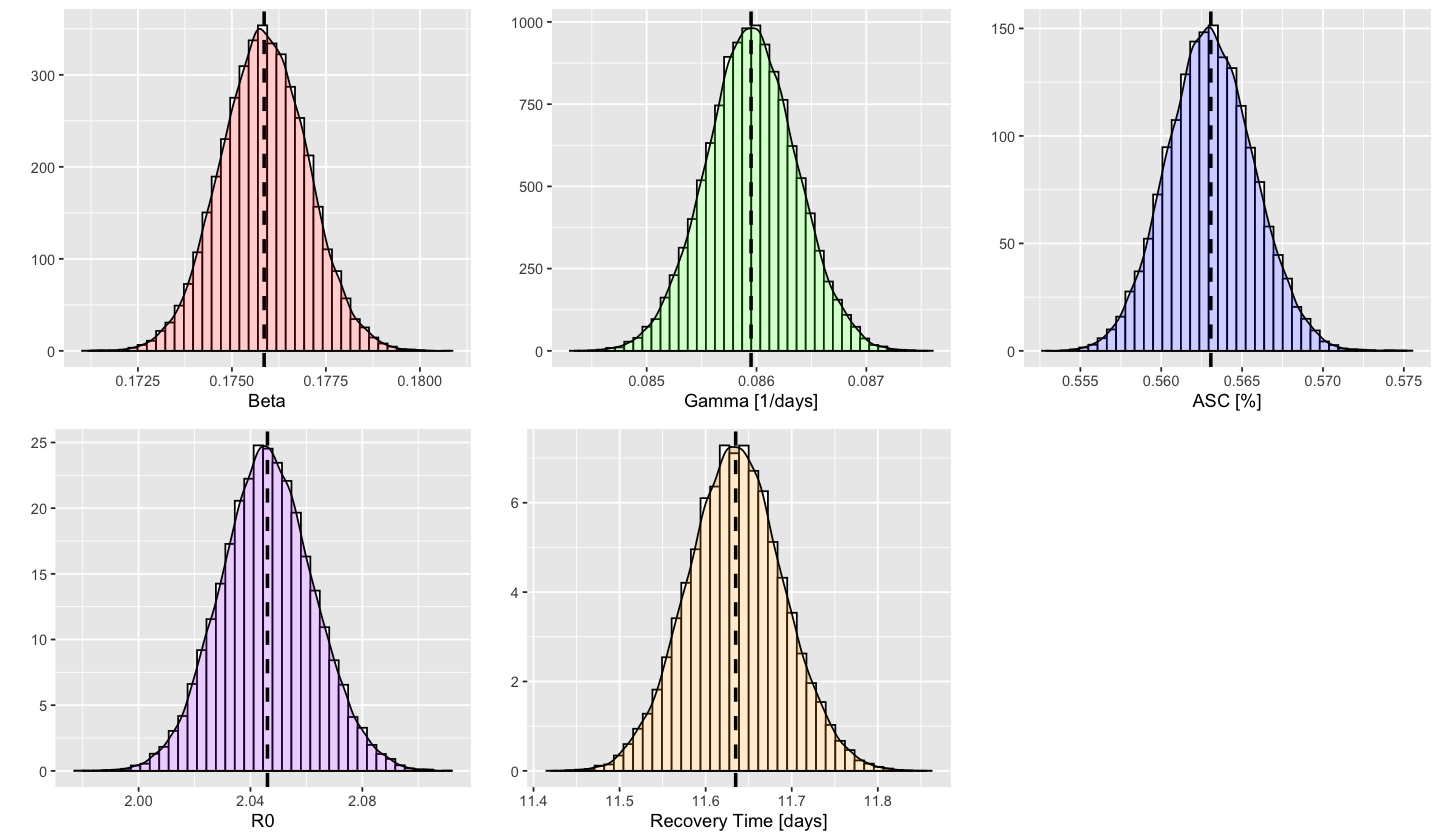

In [11]:
#---POSTERIOR PLOT---

gp1 <- ggplot(val_chain, aes(x=beta_chain)) + 
  geom_histogram(aes(y=..density..), colour="black", fill="white", bins=40) +
  geom_density(alpha=.2, fill="red")+xlab("Beta")+ylab("")+
  geom_vline(aes(xintercept=summ$statistics[1]), color="black", linetype="dashed", size=1)

gp2 <- ggplot(val_chain, aes(x=gamma_chain)) + 
  geom_histogram(aes(y=..density..), colour="black", fill="white", bins=40) +
  geom_density(alpha=.2, fill="green")+xlab("Gamma [1/days]")+ylab("")+
  geom_vline(aes(xintercept=summ$statistics[2]), color="black", linetype="dashed", size=1)

gp3 <- ggplot(val_chain, aes(x=asc_chain*100)) + 
  geom_histogram(aes(y=..density..), colour="black", fill="white", bins=40) +
  geom_density(alpha=.2, fill="blue")+xlab("ASC [%]")+ylab("")+
  geom_vline(aes(xintercept=summ$statistics[3]*100), color="black", linetype="dashed", size=1)

gp4 <- ggplot(val_chain, aes(x=R0_chain)) + 
  geom_histogram(aes(y=..density..), colour="black", fill="white", bins=40) +
  geom_density(alpha=.2, fill="purple")+xlab("R0")+ylab("") +
  geom_vline(aes(xintercept=summ$statistics[5]), color="black", linetype="dashed", size=1)

gp5 <- ggplot(val_chain, aes(x=rec_time_chain)) + 
  geom_histogram(aes(y=..density..), colour="black", fill="white", bins=40) +
  geom_density(alpha=.2, fill="orange")+xlab("Recovery Time [days]")+ylab("")+
  geom_vline(aes(xintercept=summ$statistics[4]), color="black", linetype="dashed", size=1)


grid.arrange(gp1,gp2,gp3,gp4,gp5, ncol=3, nrow=2)

In [12]:
#---SUMMARY INFERENCE---
summ


Iterations = 5001:10000
Thinning interval = 1 
Number of chains = 6 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean        SD  Naive SE Time-series SE
beta      0.175856 1.145e-03 6.610e-06      1.489e-05
gamma     0.085950 4.068e-04 2.349e-06      2.917e-06
asc       0.005631 2.665e-05 1.539e-07      3.522e-07
rec_time 11.634888 5.508e-02 3.180e-04      3.950e-04
R0        2.046070 1.647e-02 9.512e-05      1.908e-04

2. Quantiles for each variable:

              2.5%       25%      50%       75%     97.5%
beta      0.173622  0.175080  0.17585  0.176636  0.178092
gamma     0.085150  0.085680  0.08595  0.086225  0.086753
asc       0.005579  0.005613  0.00563  0.005648  0.005684
rec_time 11.527014 11.597603 11.63460 11.671340 11.744024
R0        2.014072  2.035012  2.04589  2.056963  2.079036


In conclusion we can make inference on the most probably real epidemic dynamics happened in Wuhan with its 95% CI.

In [13]:
#---DYNAMIC RECONSTRUCTION---

I1 <- summary(res[,grep("I\\[", varnames(res))][1])$quantiles[,c(1,3,5)]   #Infection Prediction from 1° Chain
pred_I1 <- data.frame("time"=dates[2:(nrow(dat)+1)],"I"=I1[,2])
head(I1)


2.5%   50%    97.5%    
I[1]  11608  11718  11822.02
I[2]  25150  25389  25615.05
I[3]  41858  42256  42632.07
I[4]  61908  62497  63052.10
I[5]  86003  86821  87592.12
I[6] 115023 116117 117148.15

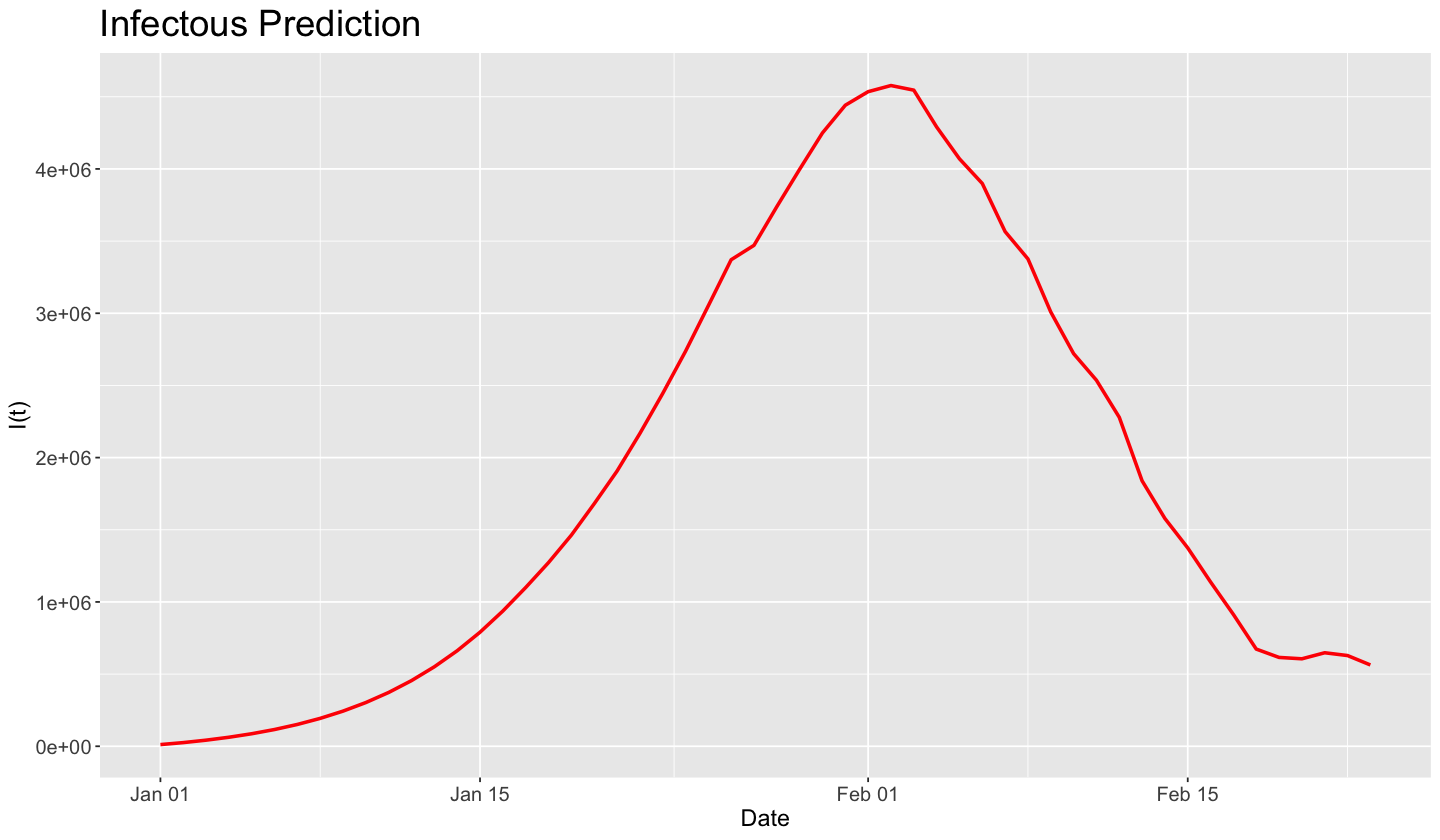

In [14]:
#---EPIDEMIC ESTIMATION---

ggplot(pred_I1, aes(x=time)) + 
geom_line(aes(y=I), color="red", size=1) + 
labs(title="Infectous Prediction", x="Date", y="I(t)")+
theme(axis.text  = element_text(size=12), axis.title  = element_text(size=14),
                 plot.title = element_text(size=22), legend.text = element_text(size=14))


### Conclusions

We can conclude saying that the estimated values $R_{0}$ and recovery time are nor exact, neither correct respect the "true" estimated ones with other models e/o tecniques, nevertheless they are reasonable respect what is found in other studies (see [2]). What we clearly can't tolerate is the estimated 95% CI of the estimated epidemic, it's too strict and we seriouslty doubt about it. But this, again, is due the SIR model **AND** the simplicistic JAGS model employed that nevertheless allow us to give a meaningfull interpretation on what is going on.  

That's why we move on into the next section where we will introduce the SEIR model.

## The SEIR Model 

## SEIR Model - Brief Introduction

We transform the SIR model into a SEIR model, adding an another compartment called E where people **Exposed** 
to virus are **NOT contagious** whereas Infectious people are.

Furthermore, we suppose that people are reported as soon as they become Infectious. We add a parameter $a$, **incubation rate**, where $\frac{1}{a} $ corresponds to the average time between being infected and becoming infectious (for simplicity we also use $\frac{1}{a} $ as the time between being infected and being reported).

The equations for the SEIR model are:

$$
\begin{cases}
\begin{align}
\frac{dS}{dt} &=-\beta\frac{SI}{N}\\
\frac{dE}{dt} &=+\beta\frac{SI}{N}-aE\\
\frac{dI}{dt} &=+ aE -\gamma I \\
\frac{dR}{dt} &=+\gamma I \\
\end{align}
\end{cases}
$$


![alt text](SEIR.jpg "Title")

# Stan forcing model details

For our scope SEIR model takes also in account **underrepporting**, **varying initial infections** and **restriction measures**

### Blocks


1. In the **function** block we define two sub-functions: **switch_eta** and **sir**.

The first one describes a tentative to model the restriction measures imposed by chinese government in order 
to contain the contagious.
The control measures are modelled as sigmoid function 𝑓(𝑡) :

 $$f(t)=η+\frac{1−\eta}{1+\exp [\xi*(t−t1−\nu) ]} $$


where:

$\eta$ is the decrease of transmission while control measures are fully in place,                                   
$\xi$ is the slope of the decrease,                                                                               
$\nu$ is the delay (after the date of introduction of control measures) until the measures are 50 % effective,starting from $t_{1}$: instant when restriction measures start.

So with restriction measures the transmition rate $\beta(t)$ become variable  and in particular 
we have:

$$ \beta(t)=f(t)\beta $$




2. In the **sir** function we implement **seir** model with his only 8 parameters out 10 included in the model itself: $\beta ,\gamma, a,\eta,\nu,\xi,i_0,e_0 $ .                                                                                                           
    $i_0$ are initial infected individuals and $e_0$ initial exposed individuals not fixed but both extracted from $N(0,10)$ distribution

3. In the **data** block we collect the starting values passed when sampling procedure starts and in the 
   **trasformed data** where we declare additional fixed variables and do operations on
    variables declared in data and in this block.


4. In the **parameters** block we include all the 10 parameters sampled: $\beta ,\gamma, a,\phi^{-1},\eta,\nu,    \xi,p_{reported},i_0,e_0 $.

    The $p_{reported}$ parameter takes in account undereporting cases and $\phi^{-1}$ is a dispertion parameter.

5.  In the **model** block we collect all the priors and the likelihood for the Bayesian inference.

6.  In the **generated quantities** block we run operations on all previously declared variables to compute 
    quantities of interest, such as $R_0$, incubation time, predicted cases and so on.

In [7]:
seir_forcing_model = "
functions {
  real switch_eta(real t, real t1, real eta, real nu, real xi) {
    return(eta + (1 - eta) / (1 + exp(xi * (t - t1 - nu))));
  }
  real[] sir(real t, real[] y, real[] theta, 
             real[] x_r, int[] x_i) {

      int N = x_i[1];
      real tswitch = x_r[1];
      
      real beta = theta[1];
      real gamma = theta[2];
      real a = theta[3];
      real eta = theta[4]; // reduction in transmission rate after quarantine
      real nu = theta[5]; // shift of quarantine implementation
      real xi = theta[6]; // slope of quarantine implementation
      real i0 = theta[7];
      real e0 = theta[8];
      real forcing_function = switch_eta(t,tswitch,eta,nu,xi);   // switch function
      real beta_eff = beta * forcing_function;                   // beta decreased to take control measures into account
      real init[4] = {N - i0 - e0, e0, i0, 0};                   // initial values

      real S = y[1] + init[1];
      real E = y[2] + init[2];
      real I = y[3] + init[3];
      real R = y[4] + init[4];
      
      real dS_dt = -beta_eff * I * S / N;
      real dE_dt =  beta_eff * I * S / N - a * E;
      real dI_dt = a * E - gamma * I;
      real dR_dt =  gamma * I;
      
      return {dS_dt, dE_dt, dI_dt, dR_dt};
  }
}
data {
  int<lower=1> n_days;
  real t0;
  real tswitch; // date of introduction of control measures
  real ts[n_days];
  int N; // population size
  int cases[n_days];
}
transformed data {
  int x_i[1] = { N };
  real x_r[1] = {tswitch};
}
parameters {
  real<lower=0> gamma;
  real<lower=0> beta;
  real<lower=0> a;
  real<lower=0> phi_inv;
  real<lower=0,upper=1> eta;          // reduction in transmission due to control measures (in proportion of beta)
  real<lower=0> nu;                   // shift of quarantine implementation (strictly positive as it can only occur after tswitch)
  real<lower=0,upper=1> xi_raw;       // slope of quarantine implementation (strictly positive as the logistic must be downward)
  real<lower=0, upper=1> p_reported;  // proportion of infected (symptomatic) people reported
  real<lower=0> i0;                   // number of infected people inititally
  real<lower=0> e0;
}
transformed parameters{
  real y[n_days, 4];
  real incidence[n_days - 1];
  real phi = 1. / phi_inv;
  real xi = xi_raw + 0.5;
  real theta[8];
  theta = {beta, gamma, a, eta, nu, xi, i0, e0};
  y = integrate_ode_rk45(sir, rep_array(0.0, 4), t0, ts, theta, x_r, x_i);
  for (i in 1:n_days-1){
    incidence[i] = -(y[i+1, 2] - y[i, 2] + y[i+1, 1] - y[i, 1]) * p_reported + 0.00001; //-(E(t+1) - E(t) + S(t+1) - S(t))
  }
}
model {
  //priors
  beta ~ normal(2, 0.5);
  gamma ~ normal(0.4, 0.5);
  a ~ normal(0.4, 0.5);
  phi_inv ~ exponential(5);
  i0 ~ normal(0, 10);
  e0 ~ normal(0, 10);
  p_reported ~ beta(1, 2);
  eta ~ beta(2.5, 4);
  nu ~ exponential(1./5);
  xi_raw ~ beta(1, 1);
  
  //sampling distribution
  //col(matrix x, int n) - The n-th column of matrix x. Here the number of infected people 
  cases[1:(n_days-1)] ~ neg_binomial_2(incidence, phi+ 0.00001);
}
generated quantities {
  real R0 = beta / gamma;
  real Reff[n_days];
  real recovery_time = 1 / gamma;
  real incubation_time = 1 / a;
  real pred_cases[n_days-1];
  pred_cases = neg_binomial_2_rng(incidence, phi+ 0.00001);
  for (i in 1:n_days)
    Reff[i] = switch_eta(i, tswitch, eta, nu, xi) * beta / gamma;
}
"

## Data

In [2]:
# row dataset
china_dataset <- load(url("https://github.com/thlytras/nCoVasc/blob/master/dat.RData?raw=true"))

In [3]:
# cut-off first initial part and compute new cases per day
starting_date <- "2020-1-1"
dat <- data.frame(time=seq.Date(as.Date(starting_date), wuhan$time[nrow(wuhan)], by="day"))
dat <- merge(dat, wuhan, all.x=TRUE)
dat$rep <- c(NA, diff(dat$cum_confirm))
dat <- dat[-1, c("time","rep")]
rownames(dat) <- NULL

In [4]:
##diff
diff <- as.numeric(as.Date("2020-1-3") - as.Date(starting_date))

#lower and upper bound respect to the date reported to article [2b]
lb <- 39+diff
ub <- 41+diff

In [5]:
#handling dataset
est40 <- round(mean(dat$rep[c(lb,ub)]))
dat$rep[1:lb] <- dat$rep[1:lb] + round(dat$rep[1:lb]/sum(dat$rep[1:lb])*(dat$rep[ub-1]-est40))
dat$rep[ub-1] <- est40

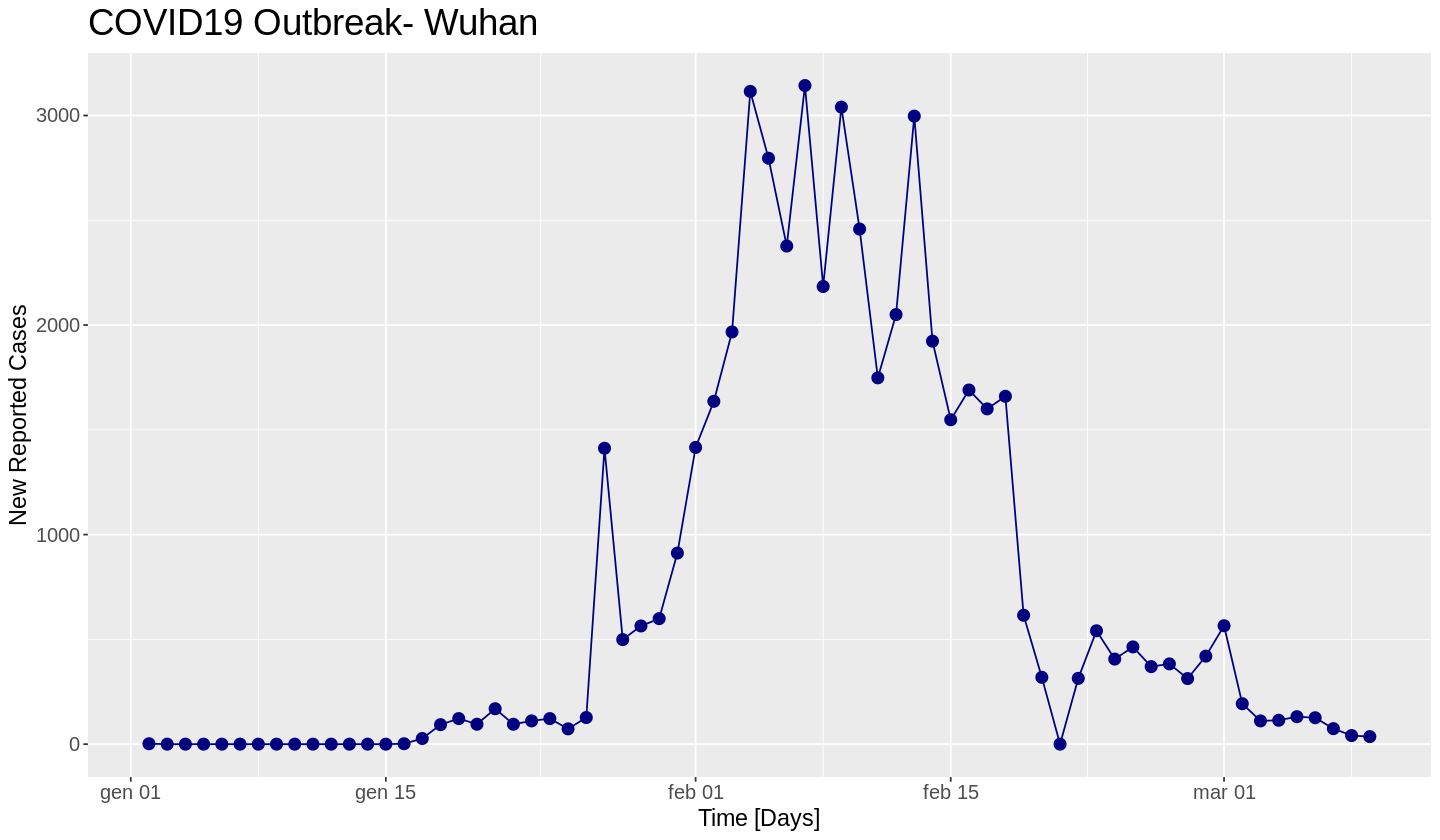

In [6]:
#plot
ggplot() + geom_line( data=dat, aes(x=time, y=rep), color = "navy") +
           geom_point( data=dat, aes(x=time, y=rep),color="navy", cex = 3) +
           labs(title = "COVID19 Outbreak- Wuhan", x = "Time [Days]", y = "New Reported Cases")+
           theme(axis.text=element_text(size=12), axis.title=element_text(size=14),
           plot.title = element_text(size=22))


In [8]:
N <- 11E6 #population

# Cases
cases <- dat$rep

#parameters
n_days <- length(cases)
ts <- seq(1, n_days, by = 1)
t0 = 0

#qurantine 
date_switch <-"2020-01-23" 
tswitch <- length( dat$time[(dat$time < date_switch)] ) +1

data_covid_forcing <- list(n_days = n_days,t0 = t0, ts = ts, N = N, cases = cases,tswitch = tswitch)

### Loading model

In [9]:
wuhan_forcing_model<- stan_model(model_code = seir_forcing_model)

In [10]:
fit_forcing <- sampling(wuhan_forcing_model, 
                     data_covid_forcing,
                     control = list(max_treedepth = 13, adapt_delta=0.88),
                     chains=4,
                     iter = 2000,
                     seed = 4)

In [11]:
check_hmc_diagnostics(fit_forcing)


Divergences:


407 of 4000 iterations ended with a divergence (10.175%).
Try increasing 'adapt_delta' to remove the divergences.



Tree depth:


0 of 4000 iterations saturated the maximum tree depth of 13.



Energy:


E-BFMI indicated no pathological behavior.


In [12]:
pars = c("beta", "gamma","phi_inv","a", "p_reported", "nu", "xi", "eta")

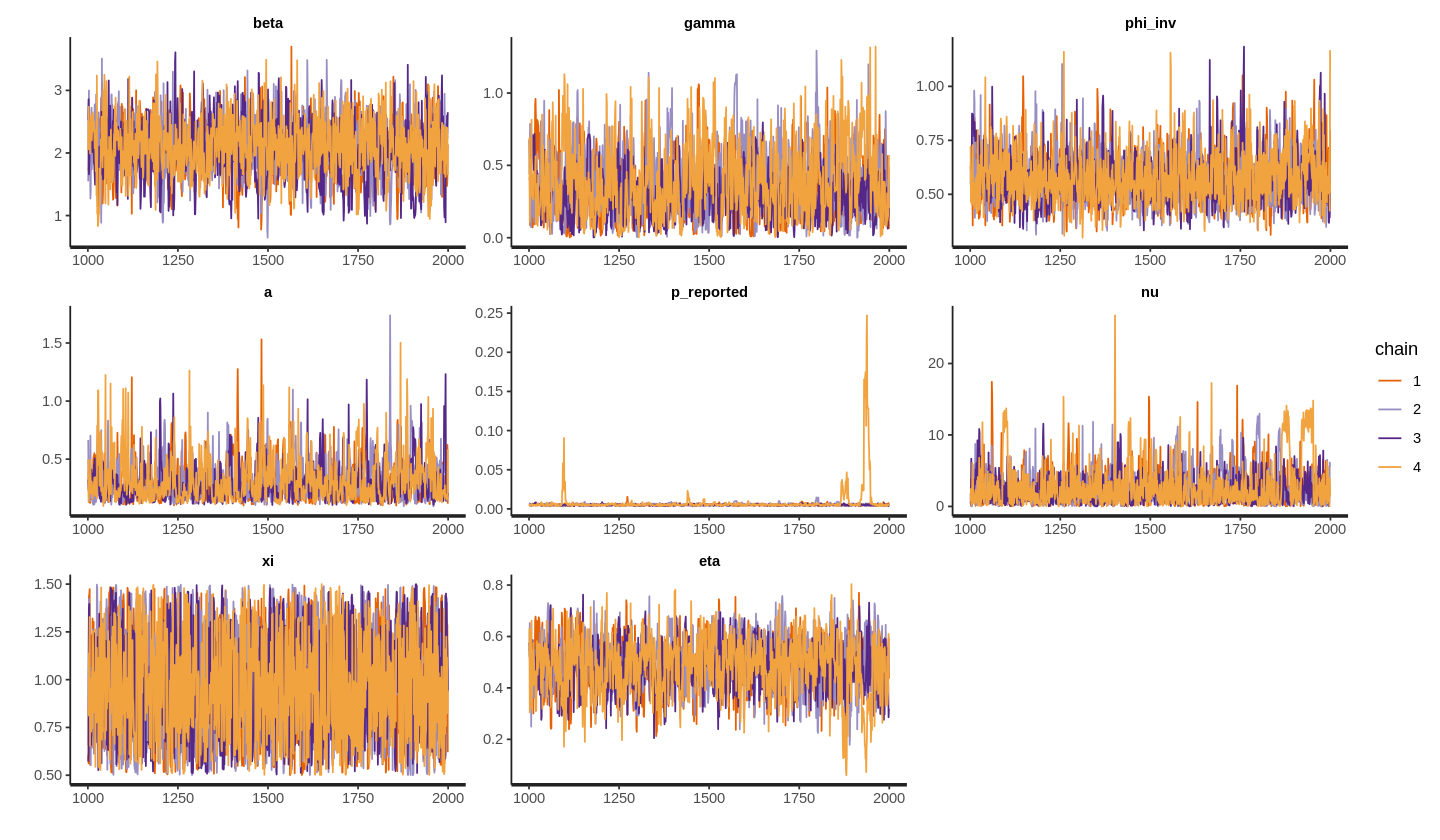

In [13]:
traceplot(fit_forcing, pars = pars, nrow=3)

### Parameters Results

We look at the pairs plot to analyse the inferred posterior distribution. 
A pairs plot shows the coupled values of pairs of parameters.  

This plot is useful to grasp the geometry of the posterior.

In [14]:
print(fit_forcing, pars = pars)

Inference for Stan model: b22d25c158383f36711b0ddcbd4ef719.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
beta       2.06    0.01 0.45 1.17 1.76 2.06 2.36  2.96  1597 1.00
gamma      0.35    0.01 0.22 0.03 0.18 0.32 0.49  0.86   535 1.01
phi_inv    0.58    0.00 0.12 0.38 0.49 0.56 0.64  0.85  1839 1.00
a          0.31    0.01 0.18 0.12 0.18 0.26 0.39  0.75   933 1.00
p_reported 0.01    0.00 0.01 0.00 0.00 0.01 0.01  0.01   231 1.02
nu         2.44    0.11 2.55 0.05 0.69 1.64 3.30 10.28   514 1.01
xi         0.97    0.01 0.28 0.52 0.72 0.95 1.21  1.47  2546 1.00
eta        0.49    0.00 0.10 0.29 0.42 0.49 0.56  0.67   953 1.00

Samples were drawn using NUTS(diag_e) at Sun Jun 20 12:06:50 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1

As seen above for all the parameters choosen the 4 Markov chains are well mixed and $\hat{R}$ is near to one.      
The only issues can be related to 10% of divergence but increasing **adapt_delta** parameter the sampling becomes **too** slow

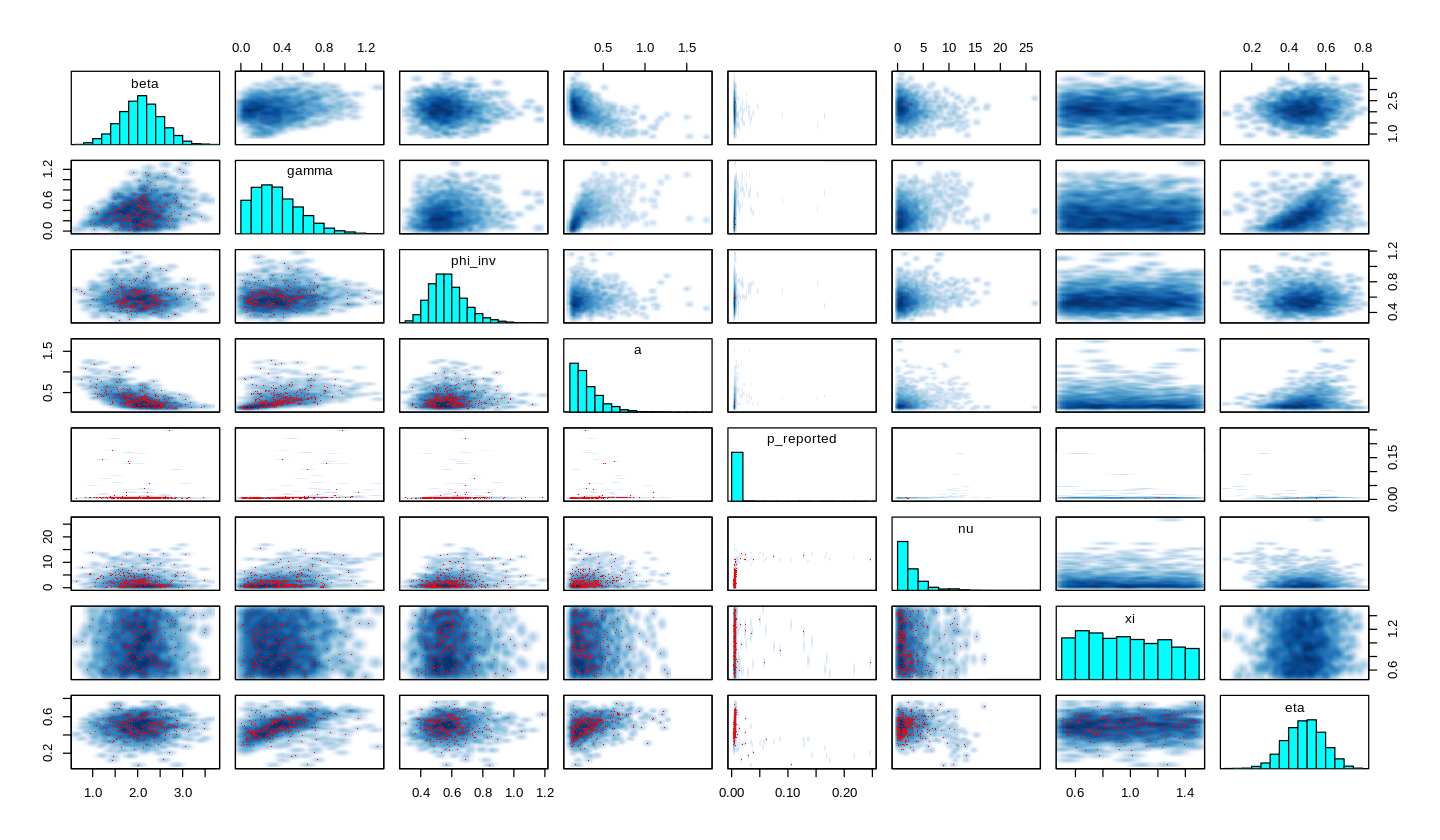

In [15]:
pairs(fit_forcing, pars = pars )

### Fitting Incidence

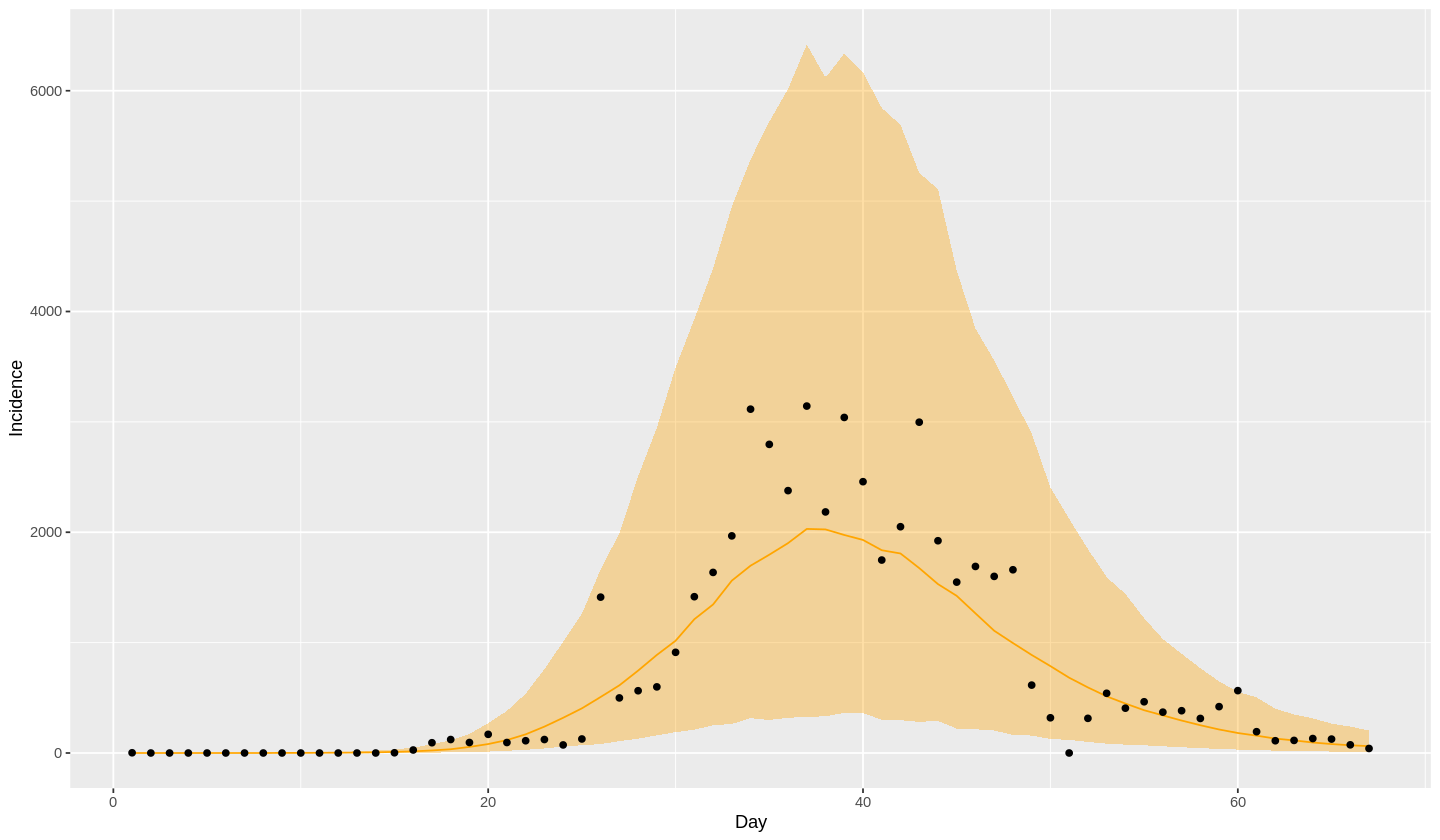

In [19]:
smr_pred <- cbind(as.data.frame(summary(fit_forcing, pars = "pred_cases", probs = c(0.05, 0.5, 0.95))$summary), 
                  t=1:(n_days-1), cases = cases[1:length(cases)-1]) 

colnames(smr_pred) <- make.names(colnames(smr_pred)) # to remove % in the col names

ggplot(smr_pred, mapping = aes(x = t)) +
  geom_ribbon(aes(ymin = X5., ymax = X95.), fill = c_posterior, alpha=0.35) +
  geom_line(mapping = aes(x = t, y = X50.), color = c_posterior) +
  geom_point(mapping = aes(y = cases)) +
  labs(x = "Day", y = "Incidence")

### Estimate of $R_{0}$
We may be also interested on how the parameter $R_{0}(t)$, which corresponds to the average number of people infected by someone contracting the virus at time $t$, change taking into account environmental changes modifying transmission such as people behavior or governmental policies.

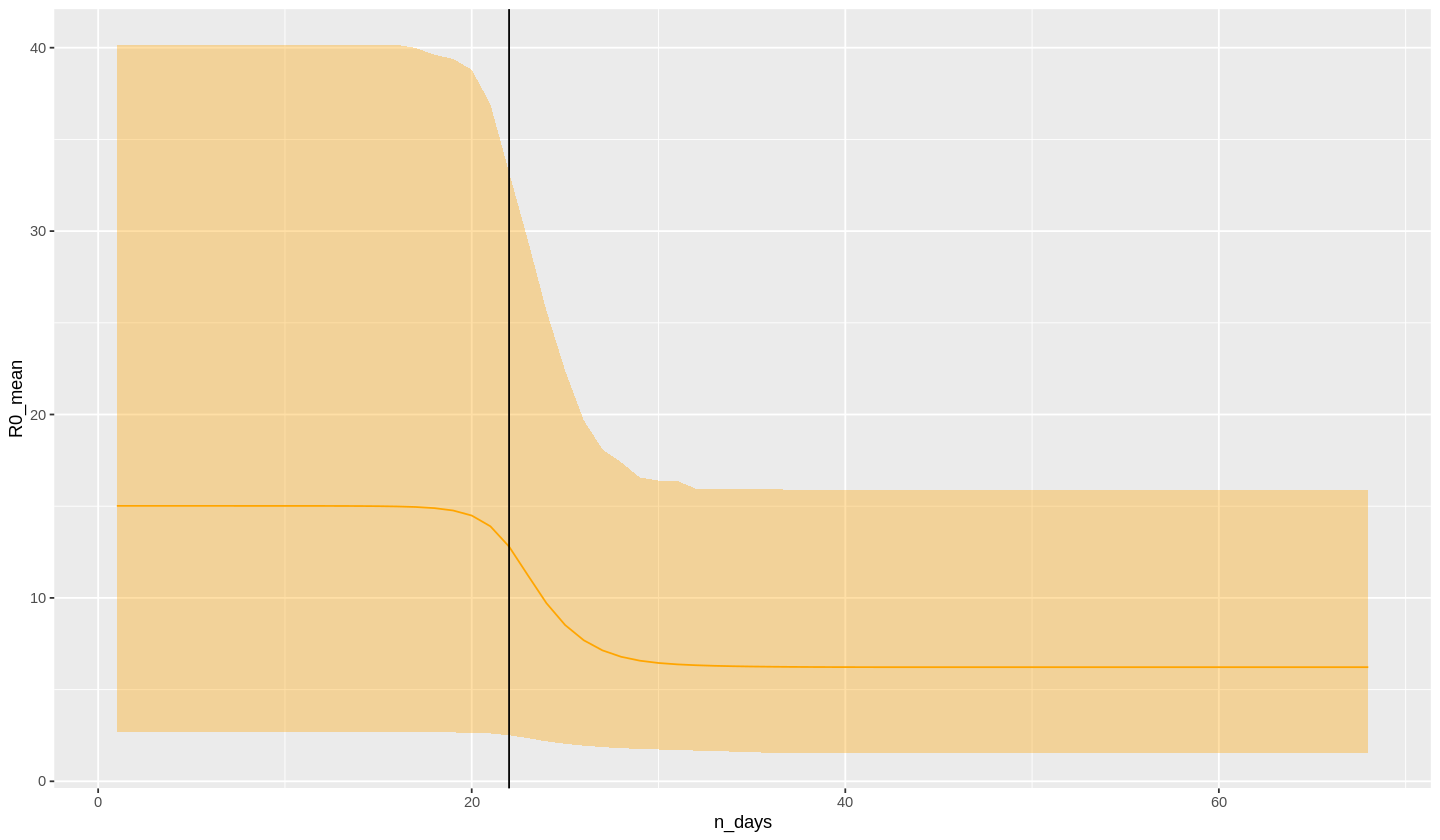

In [20]:
fit_forcing %>% 
  spread_draws(Reff[n_days]) %>% 
  group_by(n_days) %>% 
  summarise(R0_mean = mean(Reff), R09 = quantile(Reff, 0.95), R01 = quantile(Reff, 0.05)) %>% 
  ggplot() +
  geom_ribbon(aes(x = n_days, ymin = R01, ymax = R09), fill = c_posterior, alpha=0.35)+
  geom_line(mapping = aes(n_days, R0_mean), color = c_posterior) +
  geom_vline(aes(xintercept = tswitch))

### Prior-Posterior Parameters

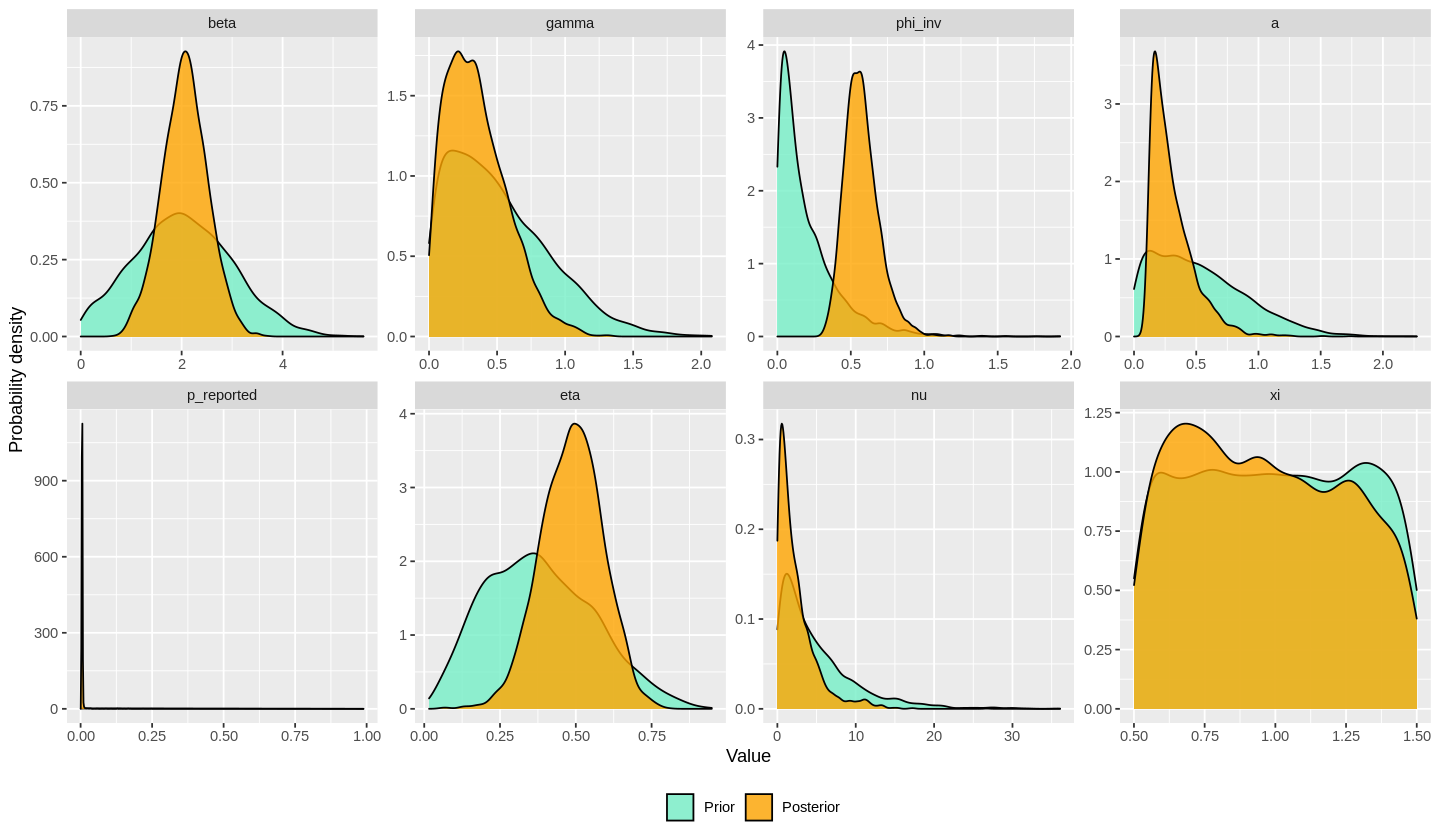

In [21]:
n = 4000
prior = tibble(
  beta = abs(rnorm(n,2,1)),
  gamma = abs(rnorm(n,.4,.5)),
  a = abs(rnorm(n,.4,.5)),
  phi_inv = rexp(n,5),
  p_reported = rbeta(n, 1, 2),
  eta = rbeta(n, 2.5, 4),
  nu = rexp(n,1./5),
  xi = .5 + rbeta(n,1, 1)
) %>%
  pivot_longer(everything()) %>% #transpose the tibble and add a column type
  mutate(type="Prior")

pars = c("beta","gamma","phi_inv","a","p_reported","eta","nu","xi")
samp = rstan :: extract(fit_forcing,pars) %>%
  as.data.frame() %>%
  pivot_longer(everything()) %>%
  mutate(type="Posterior") %>%        #add dataframe with type posterior
 bind_rows(prior) %>%
  mutate(name=factor(name,levels=pars),
         type=factor(type,levels=c("Prior","Posterior")))

ggplot(samp) +
  geom_density(aes(x=value,fill=type),alpha=.8) +
  facet_wrap(~name,scale = "free",ncol=4) +
  scale_fill_manual(values = c(c_prior,c_posterior)) +
  labs(x="Value",y="Probability density",fill=NULL) +
  theme(legend.position="bottom")

### Conclusions

Using **SEIR model + underreporting case + varying initial infections + forcing** allow us to go into a brief tour on real epigemiological model and we've learned also how to handle real epidemiological data. Moreover we've seen how we can introduce difficult concepts as Forcing and Under-reporting inside an epidemiological model. 

A brief discussion of the previous results however is needed:  
* $\pmb{R_{0}}$ is totally irrelistic starting around 15 and finishes around 6. 
* The 95% CI around our data is very large as can be seen from the plot above.

The Inference didn't go too well and considering that we seriously doubt about this incredibly high $R_{0}$ we are tempted to say "Well, also this model is too semplistict"; maybe not this time.  
If we handle for example data reported from Ginevra as done in other works (see [1]), we can appreciate a perfect fit of the data, where $R_{0}$ and the 95% CI are reasonable!  
If we add this results to what we've found before, we can conclude that we really should doubt about data reported from Wuhan.

### References

1a. https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations

2a. https://mc-stan.org/docs/2_27/stan-users-guide/ode-solver-chapter.html

3a. https://www.rdocumentation.org/packages/EpiDynamics/versions/0.3.1/topics/SIR

0b. https://www.covid19.uga.edu/nowcast-US-ascertainment.html

1b. https://covid19.sph.hku.hk/recent-media-revisions-of-case-definitions

2b. https://www.medrxiv.org/content/10.1101/2020.03.24.20042218v1.full.pdf

3b. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7094774/

4b. http://tesi.cab.unipd.it/39638/1/tesi.pdf

1c. https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html
